## Project Setup

In [47]:
# all import statements needed for the project, for example:
import os
import bs4
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import requests
import sqlalchemy as db
import re
from datetime import datetime, timedelta
import numpy as np
import fiona
import math
import pytest
from shapely.geometry import Point
from typing import Optional, Tuple, List
from matplotlib.animation import FuncAnimation
from sqlalchemy import text as db_text
import seaborn as sns
import folium
from folium.plugins import HeatMap
from IPython.display import IFrame
from sqlalchemy import create_engine

To accomplish our project, we use several libraries to handle tasks such as data processing, visualization, database interaction, and geospatial analysis. Here’s a brief overview:

- **File and Directory Management**:
  - `os`: Helps manage directories and file paths.

- **Web Scraping**:
  - `bs4` and `BeautifulSoup`: Extract data from web pages.

- **Data Handling**:
  - `pandas`: Works with tabular datasets, like spreadsheets.
  - `geopandas`: Adds geospatial capabilities to pandas for working with maps and location data.

- **Database Interaction**:
  - `sqlalchemy`: Connects our data to a SQLite database for storage and querying.

- **Math and Statistics**:
  - `math` and `numpy`: Perform calculations and handle arrays of data.

- **Date and Time**:
  - `datetime`: Manage dates and times for our analysis.

- **Regular Expressions**:
  - `re`: Helps search for patterns in text, like extracting URLs.

- **Testing**:
  - `pytest`: Ensures our functions work as expected through automated testing.

- **Visualization**:
  - `matplotlib.pyplot`: Creates graphs and charts to visualize trends and patterns.

- **Geospatial Data**:
  - `fiona`, `shapely`, and `GeoDataFrame`: Handle maps, locations, and geographic shapes.

This mix of tools enables us to handle various aspects of the project, from downloading and cleaning data to storing it in a database and creating visualizations.


In [50]:
# any constants you might need; some have been added for you, and 
# some you need to fill in

TLC_URL = "https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = ""
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
WEATHER_CSV_DIR = ""

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Defining Project Constants

Constants are fixed values that we use throughout the project. By defining them in one place, it’s easier to maintain consistency and make changes if needed. Below is a simplified explanation of the constants used in the project:

### Data Source URLs
- **`TLC_URL`**:  
  The website link where we download ride data for New York City, including taxi and Uber trips.

### Taxi Zones Information
- **`TAXI_ZONES_DIR`**:  
  The folder where information about NYC taxi zones is stored.
- **`TAXI_ZONES_SHAPEFILE`**:  
  A file that maps the boundaries of taxi zones in NYC. This is important for identifying pickup and drop-off locations geographically.

### Weather Data Location
- **`WEATHER_CSV_DIR`**:  
  The folder where we keep cleaned weather data files.

### Geographic Settings
- **`CRS`**:  
  This stands for "Coordinate Reference System," a standard used to define locations on Earth (here, latitude and longitude).

#### Bounding Boxes for Geographic Areas
Bounding boxes are defined by latitude and longitude pairs and are used to filter rides or weather data based on specific locations:
- **`NEW_YORK_BOX_COORDS`**:  
  The boundaries of New York City. Used to filter rides within the city.
- **`LGA_BOX_COORDS`**:  
  The boundaries of LaGuardia Airport.
- **`JFK_BOX_COORDS`**:  
  The boundaries of John F. Kennedy International Airport.
- **`EWR_BOX_COORDS`**:  
  The boundaries of Newark Liberty International Airport.

### Database Configuration
- **`DATABASE_URL`**:  
  The location of the SQLite database where all cleaned data will be stored.
- **`DATABASE_SCHEMA_FILE`**:  
  A file that defines the structure (or schema) of the database tables.
- **`QUERY_DIRECTORY`**:  
  A folder where SQL query files for analysis will be saved.


In [53]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Ensuring the Existence of the Query Directory

This part of the code ensures that the folder (directory) where we will save our SQL query files is created and ready to use. The directory is defined by the constant `QUERY_DIRECTORY`.

### Why Is This Important?
During the project, we will generate and save SQL query files. To do this, we need a specific folder to keep them organized. This code checks if the folder already exists, and if not, it creates it.

### How It Works
1. **Create the Folder**:  
   The program attempts to create the folder specified by `QUERY_DIRECTORY`.

2. **Handle Existing Folders**:  
   - If the folder already exists, Python might raise an error. The code is designed to detect this specific situation and ignore the error, allowing the program to continue running without issues.
   - If a different error occurs (unrelated to the folder already existing), the program will stop and notify the user.

This process ensures the folder is always available without accidentally overwriting or creating duplicate folders.

By doing this early in the program, we avoid problems later when saving query files, keeping everything organized and efficient.


# Part 1: Data Preprocessing

## Load Taxi Zones

This section focuses on handling geographic data related to NYC taxi zones, which is essential for mapping and analyzing taxi and Uber rides.

### 1. Loading Taxi Zone Information

We use the **`load_taxi_zones`** function to load data about taxi zones from a geospatial file, such as a shapefile or GeoJSON. This data is stored in a **GeoDataFrame**, which allows us to perform geographic operations (e.g., finding locations or boundaries).

#### Why Is This Important?
- Taxi zones help us identify where rides start and end geographically.
- This information is used throughout the project for mapping and spatial analysis.

### 2. Getting the Coordinates for a Taxi Zone

The **`lookup_coords_for_taxi_zone_id`** function helps find the central point (latitude and longitude) of a taxi zone using its **LocationID**.

#### How It Works:
- If the LocationID is valid, the function calculates the **centroid** (geographic center) of the taxi zone and returns the coordinates (latitude and longitude).
- If the LocationID is not found, the function returns `None`, indicating the zone is invalid or missing.

#### Why Is This Important?
- Coordinates allow us to connect geographic zones with ride data, making it possible to analyze trips based on pickup and drop-off locations.
- This is especially helpful for visualizing the data on maps or filtering rides by specific areas.

These functions are crucial for linking spatial data with ride information, enabling us to analyze and visualize geographic trends effectively.

In [4]:
def load_taxi_zones(file_path: str) -> GeoDataFrame:
    """
    Load taxi zones from a shapefile or GeoJSON file into a GeoDataFrame.

    Args:
        file_path (str): The path to the geospatial file (e.g., a shapefile or GeoJSON).

    Returns:
        GeoDataFrame: A GeoDataFrame containing the taxi zones data.
    """
    geofile: GeoDataFrame = gpd.read_file(file_path)
    return geofile

In [5]:
taxi_zones = load_taxi_zones("taxi_zones/taxi_zones.shp")

In [14]:
def lookup_coords_for_taxi_zone_id(
    zone_loc_id: int, 
    loaded_taxi_zones: GeoDataFrame
) -> Optional[Tuple[float, float]]:
    """
    Look up the latitude and longitude coordinates for a taxi zone by its LocationID.

    Args:
        zone_loc_id (int): The LocationID of the taxi zone.
        loaded_taxi_zones (GeoDataFrame): A GeoDataFrame containing taxi zone geometries.

    Returns:
        Optional[Tuple[float, float]]: A tuple containing the latitude and longitude 
        coordinates if the zone is found, or None if the LocationID is not in the data.
    """
    # Ensure the CRS is set if missing
    if loaded_taxi_zones.crs is None:
        loaded_taxi_zones = loaded_taxi_zones.set_crs(epsg=2263)

    # Find the zone matching the LocationID
    zone = loaded_taxi_zones[loaded_taxi_zones['LocationID'] == zone_loc_id]
    if zone.empty:
        return None
    projected_zone = zone.to_crs(epsg=2263)
    centroid = projected_zone.geometry.centroid.iloc[0]
    centroid_geo = gpd.GeoSeries([centroid], crs=2263).to_crs(epsg=4326)

    # Return latitude and longitude as a tuple
    return (centroid_geo.geometry.iloc[0].y, centroid_geo.geometry.iloc[0].x)

## Calculate Sample Size

This section explains how we determine the required sample size for analyzing large datasets. We use a statistical method called **Cochran's formula**, which is adjusted for finite population sizes.

### Purpose
When working with massive datasets, analyzing every single data point can be inefficient. Instead, we calculate a representative sample size to ensure accurate results while saving time and resources.

### Function: `calculate_sample_size`

This function calculates the sample size based on the population size and desired statistical confidence.

#### Inputs:
1. **`population`**: The total number of available data points.
2. **`p`** (default: 0.5): Represents the proportion of the population with the characteristic of interest. A default of 0.5 is used for maximum variability, meaning we assume the most uncertain case.

#### Process:
1. **Confidence Level**: The function uses a Z-value of **1.96**, which corresponds to a **95% confidence level**.
2. **Margin of Error**: Assumes a **5% margin of error** by default.
3. **Cochran's Formula**: The initial sample size (`n_0`) is calculated using the formula:
   $$
   n_0 = \frac{Z^2 \cdot p \cdot (1-p)}{(\text{margin of error})^2}
   $$
4. **Adjustment for Finite Population**: The sample size is refined to account for finite population sizes:
   $$
   \text{Adjusted Sample Size} = \frac{n_0}{1 + \frac{n_0 - 1}{\text{population}}}
   $$

#### Output:
- The function returns the **adjusted sample size**, rounded up to the nearest whole number.

#### Why Is This Important?
- Ensures the sample is large enough to represent the dataset accurately.
- Reduces the computational load by avoiding the need to process the entire dataset.
- Maintains statistical reliability for analysis.

In [17]:
def calculate_sample_size(population: int, p: float = 0.5) -> int:
    """
    Calculate the required sample size using Cochran's formula, adjusted for finite populations.

    Args:
        population (int): The total population size.
        p (float, optional): Proportion of the population with the desired characteristic. 
            Defaults to 0.5 for maximum variability.

    Returns:
        int: The calculated sample size, rounded up to the nearest whole number.
    """
    # Z-value for 95% confidence level
    z: float = 1.96
    
    # Margin of error (5% by default)
    margin_of_error: float = 0.05
    
    # Complementary proportion
    q: float = 1 - p
    
    # Cochran's formula
    n_0: float = (z**2 * p * q) / (margin_of_error**2)
    
    # Adjust for finite population
    sample_size: float = n_0 / (1 + (n_0 - 1) / population)
    
    return math.ceil(sample_size)

## Common Functions

This section provides two utility functions that automate the process of retrieving and filtering dataset links from a webpage. These functions help streamline the downloading of required files for the project. (By calling function directly, we can speed up the progress without rewriting the code again and again)

### 1. `get_all_urls_from_page`

#### Purpose:
- Extracts all web links (URLs) from a given webpage.

#### Key Features:
- **Fetching the Webpage**: Uses the `requests` library to download the HTML content of the page.
- **Parsing Links**: Employs `BeautifulSoup` to find all anchor tags (`<a>`) with `href` attributes, which contain the links.
- **Error Handling**: Ensures the function handles connectivity issues or invalid webpages gracefully, raising descriptive errors when necessary.

---

### 2. `filter_parquet_urls`

#### Purpose:
- Filters the list of extracted links to include only Parquet files.

#### Key Features:
- **URL Normalization**: Strips unnecessary whitespace from each link.
- **Regular Expression Matching**: Uses a pattern to identify URLs that end with `.parquet` (e.g., `file.parquet` or `file.parquet?params`).
- **Efficient Filtering**: Ensures only relevant file links are returned, saving time and effort during the data downloading process.

---

### Why Are These Functions Important?

- They automate the process of collecting and filtering dataset links, eliminating the need for manual URL extraction.
- Ensures consistency and accuracy in identifying the correct file formats (e.g., Parquet files) needed for the project.
- Saves significant time when dealing with large or frequently updated webpages containing multiple links.


In [20]:
def get_all_urls_from_page(page_url: str) -> List[str]:
    """
    Fetch all URLs from a given webpage.

    Args:
        page_url (str): URL of the webpage to scrape.

    Returns:
        List[str]: A list of all URLs found on the webpage.

    Raises:
        Exception: If there is an error accessing the webpage or scraping its content.
    """
    try:
        response = requests.get(page_url)
        response.raise_for_status()  # Raise an HTTPError for bad responses
    except requests.exceptions.RequestException as e:
        raise Exception(f"Failed to access the URL: {page_url}. Error: {e}")
    
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.content, "html.parser")
    links = soup.find_all("a", href=True)
    all_urls: List[str] = [link["href"] for link in links]
    
    return all_urls

In [21]:
def filter_parquet_urls(links: List[str]) -> List[str]:
    """
    Filter a list of URLs to include only those pointing to Parquet files.

    Args:
        links (List[str]): A list of URLs to filter.

    Returns:
        List[str]: A list of URLs that point to Parquet files.
    """
    parquet_urls: List[str] = []
    for url in links:
        # Normalize the URL
        url = url.strip()
        if re.search(r"\.parquet(\?.*)?$", url):
            parquet_urls.append(url)
    
    return parquet_urls

## Process Taxi Data

This section processes Yellow Taxi data from the NYC Taxi & Limousine Commission (TLC) webpage after extracting all parquet urls from the website. The goal is to clean and prepare the data for analysis, ensuring it is accurate, consistent, and manageable.

### Steps Involved

#### 1. Download and Process Monthly Data
##### Function: `get_and_clean_taxi_month`
- Downloads a monthly Yellow Taxi data file in Parquet format.
- Creates a sample dataset to make large datasets more manageable.
- Saves the processed data locally for reuse.

---

#### 2. Process Multiple Files
##### Function: `get_and_clean_taxi_data`
- Collects and processes multiple Yellow Taxi files from a list of URLs.
- Combines all the monthly datasets into one comprehensive dataset.

---

#### 3. Clean and Filter the Data
##### Function: `clean_taxi_data`
This function cleans the combined dataset to make it consistent and ready for analysis:
- **Renames Columns**: Normalizes column names for consistency.
- **Data Types**: Converts data into the correct formats (e.g., dates and numbers).
- **Coordinates**: Adds latitude and longitude for pickup and drop-off zones.
- **Invalid Data**: Removes trips with errors like zero distance or invalid times.
- **NYC Bounding Box**: Filters trips to include only those within New York City's geographic boundaries.
- **Relevant Columns**: Keeps only the essential columns needed for analysis.

---

#### 4. Combine Everything
##### Function: `get_taxi_data`
- Combines the above steps to:
  1. Fetch URLs for Yellow Taxi data files from the TLC webpage.
  2. Filter URLs to keep only relevant files.
  3. Download, process, and clean the taxi data.

This process ensures the data is ready for analysis and visualization in later stages of the project.


In [24]:
def get_and_clean_taxi_month(parquet_url: str) -> pd.DataFrame:
    """
    Download, process, and sample a Yellow Taxi dataset for a given month.

    Args:
        parquet_url (str): URL of the Yellow Taxi Parquet file.

    Returns:
        pd.DataFrame: A sampled and processed DataFrame.
    """
    # Default directory for Yellow Taxi data
    save_dir = "processed_data/yellow_taxi"
    os.makedirs(save_dir, exist_ok=True)

    # Extract file name and define local path
    file_name = parquet_url.split("/")[-1]
    local_file_path = os.path.join(save_dir, file_name)

    # Download the file if not exist
    if not os.path.exists(local_file_path):
        response = requests.get(parquet_url, stream=True)
        response.raise_for_status()
        with open(local_file_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024 * 1024):  # 1MB chunks
                if chunk:
                    f.write(chunk)

    # Load the dataset
    data = pd.read_parquet(local_file_path)

    # Calculate sample size (using p = 0.5 for Yellow Taxi data)
    population = len(data)
    sample_size = calculate_sample_size(population, p = 0.5)
    sampled_data = data.sample(n=sample_size, random_state=42) if population > sample_size else data
    
    processed_file_path = os.path.join(save_dir, f"sampled_{file_name}")
    sampled_data.to_parquet(processed_file_path)
    return sampled_data


In [25]:
def get_and_clean_taxi_data(parquet_urls: List[str]) -> pd.DataFrame:
    """
    Download, process, and combine Yellow Taxi data from multiple Parquet file URLs.

    Args:
        parquet_urls (List[str]): A list of URLs pointing to Yellow Taxi Parquet files.

    Returns:
        pd.DataFrame: A combined DataFrame containing processed data from all valid Parquet files.
    """
    all_taxi_dataframes: List[pd.DataFrame] = []

    # Regex pattern for valid Yellow Taxi Parquet files (2020-2024 dates)
    yellow_taxi_pattern: re.Pattern = re.compile(
        r"yellow_tripdata_(2020-(0[1-9]|1[0-2])|202[1-3]-(0[1-9]|1[0-2])|2024-(0[1-8]))\.parquet"
    )

    # Filter URLs matching the pattern
    yellow_taxi_urls: List[str] = [url for url in parquet_urls if yellow_taxi_pattern.search(url)]

    for url in yellow_taxi_urls:
        save_dir: str = "processed_data/yellow_taxi"
        file_name: str = f"sampled_{url.split('/')[-1]}"
        processed_file_path: str = os.path.join(save_dir, file_name)

        if os.path.exists(processed_file_path):
            dataframe: pd.DataFrame = pd.read_parquet(processed_file_path)
        else:
            dataframe: pd.DataFrame = get_and_clean_taxi_month(url)

        all_taxi_dataframes.append(dataframe)

    # Combine all DataFrames into one
    taxi_data: pd.DataFrame = pd.concat(all_taxi_dataframes, ignore_index=True)

    return taxi_data

### Note for column(variable) selection
Regarding the formula (base fare + all surcharges + taxes + tolls), we calculate the total amount as follows: it is equal to fare_amount + extra + mta_tax + tip_amount + tolls_amount + improvement_surcharge + congestion_surcharge + airport_fee, we will assume the subsurcharges segment includes extra, tip_amount, improvement_surcharge, congestion_surcharge and airport_fee.

In [71]:
def clean_taxi_data(taxi_data: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the taxi data by retaining specific columns, normalizing column names,
    converting column types, and removing invalid trips. This includes unifying column names
    across different data sources using a predefined mapping.

    Args:
        taxi_data (pd.DataFrame): The input taxi data DataFrame.

    Returns:
        pd.DataFrame: The cleaned and filtered taxi data.
    """

    # Normalize column names using the column_mapping
    column_mapping = {
    'tpep_pickup_datetime': 'pickup_datetime',
    'tpep_dropoff_datetime': 'dropoff_datetime',
    'trip_distance': 'trip_miles'}
   
    taxi_data = taxi_data.rename(columns=column_mapping)

    
    # Add latitude and longitude
    taxi_data["PU_coords"] = taxi_data["PULocationID"].apply(lambda x: lookup_coords_for_taxi_zone_id(x, taxi_zones))
    taxi_data["DO_coords"] = taxi_data["DOLocationID"].apply(lambda x: lookup_coords_for_taxi_zone_id(x, taxi_zones))
    taxi_data = taxi_data.dropna(subset=["PU_coords", "DO_coords"]).reset_index(drop=True)
    taxi_data[["PU_lat", "PU_lon"]] = pd.DataFrame(taxi_data["PU_coords"].tolist(), index=taxi_data.index)
    taxi_data[["DO_lat", "DO_lon"]] = pd.DataFrame(taxi_data["DO_coords"].tolist(), index=taxi_data.index)
    taxi_data = taxi_data.drop(columns=["PU_coords", "DO_coords"])
    
    # Retain only the required columns
    required_columns = [
        'pickup_datetime', 'dropoff_datetime', 'trip_miles',
        'PU_lat', 'PU_lon', 'DO_lat', 'DO_lon', 'total_amount',
        'fare_amount', 'extra', 'mta_tax', 'tip_amount', 
        'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'airport_fee'
    ]
    taxi_data = taxi_data[required_columns]

    # Removing Invalid Data Points
    taxi_data = taxi_data[taxi_data["trip_miles"] > 0]
    taxi_data = taxi_data[taxi_data["total_amount"] > 0]
    taxi_data = taxi_data[taxi_data["fare_amount"] > 0]
    taxi_data = taxi_data[taxi_data["pickup_datetime"] < taxi_data["dropoff_datetime"]]

    #Normalize column names
    taxi_data.columns = [col.lower() for col in taxi_data.columns]

    # Normalizing and Using Appropriate Column Types
    taxi_data["pickup_datetime"] = pd.to_datetime(taxi_data["pickup_datetime"], errors="coerce")
    taxi_data["dropoff_datetime"] = pd.to_datetime(taxi_data["dropoff_datetime"], errors="coerce")
    numeric_columns = [
        "trip_miles", "pu_lat", "pu_lon", "do_lat", "do_lon", "total_amount",
        'fare_amount', 'extra', 'mta_tax', 'tip_amount', 
        'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'airport_fee'
    ]
    # Process numeric columns
    taxi_data[numeric_columns] = taxi_data[numeric_columns].apply(pd.to_numeric, errors="coerce")
    
    # Drop rows where pickup_datetime or dropoff_datetime is NaN
    taxi_data = taxi_data.dropna(subset=["pickup_datetime", "dropoff_datetime"])
    
    # Fill NaN values in numeric columns with 0
    taxi_data[numeric_columns] = taxi_data[numeric_columns].fillna(0)

    # Removing Trips Outside the Latitude/Longitude Bounding Box
    lat_min, lon_min = 40.560445, -74.242330
    lat_max, lon_max = 40.908524, -73.717047
    taxi_data = taxi_data[
        (taxi_data["pu_lat"] >= lat_min) & (taxi_data["pu_lat"] <= lat_max) &
        (taxi_data["pu_lon"] >= lon_min) & (taxi_data["pu_lon"] <= lon_max) &
        (taxi_data["do_lat"] >= lat_min) & (taxi_data["do_lat"] <= lat_max) &
        (taxi_data["do_lon"] >= lon_min) & (taxi_data["do_lon"] <= lon_max)
    ]

    # Reset index after filtering
    taxi_data = taxi_data.reset_index(drop=True)

    return taxi_data

In [73]:
def get_taxi_data() -> pd.DataFrame:
    """
    Retrieve, filter, and clean taxi data from the TLC data page.

    This function performs the following steps:
    1. Fetches all URLs from the TLC webpage.
    2. Filters the URLs to retain only those pointing to Parquet files.
    3. Downloads, processes, and combines the data from these Parquet files.

    Returns:
        pd.DataFrame: A DataFrame containing the combined and cleaned taxi data.
    """
    all_urls: list[str] = get_all_urls_from_page(TLC_URL)
    all_parquet_urls: list[str] = filter_parquet_urls(all_urls)
    taxi_data: pd.DataFrame = get_and_clean_taxi_data(all_parquet_urls)

    return taxi_data

In [75]:
taxi_data = get_taxi_data()
taxi_data = clean_taxi_data(taxi_data)

In [76]:
taxi_data.head()

,pickup_datetime,dropoff_datetime,trip_miles,pu_lat,pu_lon,do_lat,do_lon,total_amount,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee
0,2024-01-20 13:31:30,2024-01-20 14:03:25,17.14,40.646985,-73.786530,40.749914,-73.970443,90.96,70.0,0.0,0.5,8.27,6.94,1.0,2.5,0.0
1,2024-01-18 21:52:46,2024-01-18 22:03:21,2.49,40.764421,-73.977569,40.790011,-73.945750,22.50,13.5,1.0,0.5,4.00,0.00,1.0,2.5,0.0
2,2024-01-01 03:43:58,2024-01-01 03:50:47,1.84,40.866075,-73.919308,40.857779,-73.885867,12.50,10.0,1.0,0.5,0.00,0.00,1.0,0.0,0.0
3,2024-01-19 22:20:12,2024-01-19 22:50:12,3.60,40.748497,-73.992438,40.778766,-73.951010,33.95,23.3,3.5,0.5,5.65,0.00,1.0,2.5,0.0
4,2024-01-06 22:41:50,2024-01-06 22:43:24,0.04,40.791705,-73.973049,40.791705,-73.973049,6.20,3.7,1.0,0.5,0.00,0.00,1.0,0.0,0.0


In [77]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20710 entries, 0 to 20709
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   pickup_datetime        20710 non-null  datetime64[ns]
 1   dropoff_datetime       20710 non-null  datetime64[ns]
 2   trip_miles             20710 non-null  float64       
 3   pu_lat                 20710 non-null  float64       
 4   pu_lon                 20710 non-null  float64       
 5   do_lat                 20710 non-null  float64       
 6   do_lon                 20710 non-null  float64       
 7   total_amount           20710 non-null  float64       
 8   fare_amount            20710 non-null  float64       
 9   extra                  20710 non-null  float64       
 10  mta_tax                20710 non-null  float64       
 11  tip_amount             20710 non-null  float64       
 12  tolls_amount           20710 non-null  float64       
 13  i

In [78]:
taxi_data.describe()

,pickup_datetime,dropoff_datetime,trip_miles,pu_lat,pu_lon,do_lat,do_lon,total_amount,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee
count,20710,20710,20710.000000,20710.000000,20710.000000,20710.000000,20710.000000,20710.000000,20710.000000,20710.000000,20710.000000,20710.000000,20710.000000,20710.000000,20710.000000,20710.000000
mean,2022-04-29 15:32:02.506904832,2022-04-29 15:48:05.330613248,3.271791,40.753381,-73.966982,40.755782,-73.970786,22.497828,15.378428,1.221689,0.497586,2.701182,0.437548,0.551994,2.212820,0.033679
min,2020-01-01 00:11:06,2020-01-01 00:30:50,0.010000,40.576961,-74.029893,40.576961,-74.174002,1.300000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2021-02-27 01:11:26.750000128,2021-02-27 01:26:18.249999872,1.090000,40.740337,-73.989845,40.740337,-73.989845,12.800000,7.500000,0.000000,0.500000,0.000000,0.000000,0.300000,2.500000,0.000000
50%,2022-04-28 13:02:38.500000,2022-04-28 13:12:18,1.805000,40.758028,-73.977698,40.758028,-73.977698,17.020000,10.700000,0.500000,0.500000,2.160000,0.000000,0.300000,2.500000,0.000000
75%,2023-06-27 15:31:13,2023-06-27 15:53:30.500000,3.310000,40.773633,-73.961764,40.775932,-73.959635,24.500000,17.000000,2.500000,0.500000,3.450000,0.000000,1.000000,2.500000,0.000000
max,2024-08-31 22:43:47,2024-08-31 23:26:23,67.900000,40.899528,-73.739337,40.899528,-73.726655,262.700000,209.500000,11.750000,0.500000,50.000000,40.000000,1.000000,2.500000,1.250000
std,NaN,NaN,4.111148,0.032344,0.044978,0.033091,0.036046,17.358570,13.648988,1.507951,0.034661,3.160579,1.795556,0.336437,0.797188,0.202403


In [79]:
output_file = "taxi_data_cleaned.csv"

# Save the DataFrame to a CSV file
taxi_data.to_csv(output_file, index=False)

## Processing Uber Data

This section processes Uber High-Volume For-Hire (HVHF) trip data, ensuring it is clean, consistent, and ready for analysis. The process involves downloading, sampling, cleaning, and saving the data.

### Steps Involved

#### 1. Download and Sample Data
##### **Function: `get_and_clean_uber_month`**
- Downloads data for a specific month if it doesn't already exist locally.
- Samples the dataset using Cochran's formula, which ensures a manageable file size while maintaining statistical relevance.
- Saves the processed sample locally for reuse.

##### **Function: `get_and_clean_uber_data`**
- Loops through multiple Parquet file URLs for HVHF data.
- Downloads and processes each month's data, sampling where necessary.
- Combines all monthly datasets into a single, larger DataFrame.

---

#### 2. Clean and Process the Data
##### **Function: `load_and_clean_uber_data`**
This function ensures the Uber dataset is ready for analysis by performing the following steps:
- **Filter Uber Rides**: Includes only trips with the license number `HV0003` (Uber-specific rides).
- **Add Coordinates**: Converts location IDs into latitude and longitude coordinates for both pickup and dropoff locations.
- **Keep Essential Columns**: Retains only the columns required for analysis, such as:
  - Pickup/Dropoff datetime
  - Coordinates
  - Trip distance
  - Fare details
- **Remove Invalid Data**: Excludes trips with issues like:
  - Zero or negative distance
  - Negative fare amounts
  - Incorrect timestamps
- **Normalize Data**:
  - Renames columns for consistency.
  - Ensures numeric fields (e.g., distance, fares) are in the correct format.
- **Filter NYC Trips**: Keeps only trips within NYC’s geographic boundaries using latitude and longitude filtering.

---

#### 3. Combine All Steps
##### **Function: `get_uber_data`**
- Fetches all URLs for Uber HVHF Parquet files from the TLC webpage.
- Filters the URLs to retain only relevant data files.
- Downloads, processes, cleans, and combines all monthly datasets.

The cleaned Uber data is now ready for analysis and integration with other datasets like weather or Yellow Taxi data.


In [36]:
def get_and_clean_uber_month(parquet_url: str) -> pd.DataFrame:
    """
    Download, process, and sample an Uber HVHF dataset for a given month.

    Args:
        parquet_url (str): URL of the Uber HVHF Parquet file.

    Returns:
        pd.DataFrame: A sampled and processed DataFrame.
    """
    # Define the directory for processed Uber HVHF data
    save_dir: str = "processed_data/hvhf"
    os.makedirs(save_dir, exist_ok=True)

    # Extract file name and define local path
    file_name: str = parquet_url.split("/")[-1]
    local_file_path: str = os.path.join(save_dir, file_name)

    # Download the file
    if not os.path.exists(local_file_path):
        try:
            response = requests.get(parquet_url, stream=True)
            response.raise_for_status()
            with open(local_file_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=1024 * 1024):  # 1MB chunks
                    if chunk:
                        f.write(chunk)
        except requests.exceptions.RequestException as e:
            raise Exception(f"Failed to download the file from {parquet_url}. Error: {e}")
    data: pd.DataFrame = pd.read_parquet(local_file_path)

    # Sample the dataset
    population: int = len(data)
    sample_size: int = calculate_sample_size(population, p=0.4)
    sampled_data: pd.DataFrame = data.sample(n=sample_size, random_state=42) if population > sample_size else data
    processed_file_path: str = os.path.join(save_dir, f"sampled_{file_name}")
    if not os.path.exists(processed_file_path):
        sampled_data.to_parquet(processed_file_path)

    return sampled_data

In [37]:
def get_and_clean_uber_data(parquet_urls: List[str]) -> pd.DataFrame:
    """
    Download, process, and combine Uber HVHF data from multiple Parquet file URLs.

    Args:
        parquet_urls (List[str]): A list of URLs pointing to Uber HVHF Parquet files.

    Returns:
        pd.DataFrame: A combined DataFrame containing processed data from all valid Parquet files.
    """
    all_uber_dataframes: List[pd.DataFrame] = []

    # Regex pattern to filter Uber HVHF Parquet files for specific dates (2020-2024)
    hvfhv_pattern: re.Pattern = re.compile(
        r"fhvhv_tripdata_(2020-(0[1-9]|1[0-2])|202[1-3]-(0[1-9]|1[0-2])|2024-(0[1-8]))\.parquet"
    )
    hvfhv_urls: List[str] = [url for url in parquet_urls if hvfhv_pattern.search(url)]

    for url in hvfhv_urls:
        save_dir: str = "processed_data/hvhf"
        file_name: str = f"sampled_{url.split('/')[-1]}"
        processed_file_path: str = os.path.join(save_dir, file_name)

        if os.path.exists(processed_file_path):
            dataframe: pd.DataFrame = pd.read_parquet(processed_file_path)
        else:
            dataframe: pd.DataFrame = get_and_clean_uber_month(url)

        all_uber_dataframes.append(dataframe)
    uber_data: pd.DataFrame = pd.concat(all_uber_dataframes, ignore_index=True)
    return uber_data

### Note: Column (variable) selection:
Regarding the formula (base fare + all surcharges + taxes + tolls), we calculate the total amount as follows: it is equal to fare_amount + tolls + bcf + sales_tax + tips + congestion_surcharge + airport_fee, we will assume the subsurcharges segment includes bcf, tips, congestion_surcharge and airport_fee.

In [39]:
def load_and_clean_uber_data(uber_data: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and process Uber HVHF data, including filtering by license, adding coordinates,
    retaining required columns, and normalizing data.

    Args:
        uber_data (pd.DataFrame): The raw Uber HVHF data.

    Returns:
        pd.DataFrame: A cleaned and filtered DataFrame with necessary columns and normalized values.
    """
    # Filter by HVFH license number
    uber_data['hvfhs_license_num'] = uber_data['hvfhs_license_num'].astype(str)
    uber_data = uber_data[uber_data['hvfhs_license_num'] == 'HV0003'].copy()

    # Add coordinates for pickup and dropoff locations
    uber_data["PU_coords"] = uber_data["PULocationID"].apply(lambda x: lookup_coords_for_taxi_zone_id(x, taxi_zones))
    uber_data["DO_coords"] = uber_data["DOLocationID"].apply(lambda x: lookup_coords_for_taxi_zone_id(x, taxi_zones))
    uber_data = uber_data.dropna(subset=["PU_coords", "DO_coords"]).reset_index(drop=True)
    uber_data[["PU_lat", "PU_lon"]] = pd.DataFrame(uber_data["PU_coords"].tolist(), index=uber_data.index)
    uber_data[["DO_lat", "DO_lon"]] = pd.DataFrame(uber_data["DO_coords"].tolist(), index=uber_data.index)
    uber_data = uber_data.drop(columns=["PU_coords", "DO_coords"])

    # Retain required columns
    required_columns = [
        'pickup_datetime', 'dropoff_datetime', 'PU_lat', 'PU_lon', 
        'DO_lat', 'DO_lon', 'trip_miles', 'base_passenger_fare', 
        'tolls', 'bcf', 'sales_tax', 'tips', 'airport_fee', 'congestion_surcharge'
    ]
    uber_data = uber_data[required_columns]

    # Remove invalid data points
    uber_data = uber_data[uber_data["trip_miles"] > 0]
    uber_data = uber_data[uber_data["base_passenger_fare"] > 0]
    uber_data = uber_data[uber_data["pickup_datetime"] < uber_data["dropoff_datetime"]]

    # Normalize column names
    uber_data.columns = [col.lower() for col in uber_data.columns]

    # Ensure numeric columns are float or int
    numeric_columns = [
        'pu_lat', 'pu_lon', 'do_lat', 'do_lon', 'trip_miles', 
        'base_passenger_fare', 'tolls', 'bcf', 'sales_tax', 
        'tips', 'airport_fee', 'congestion_surcharge'
    ]
    uber_data[numeric_columns] = uber_data[numeric_columns].apply(pd.to_numeric, errors="coerce")

    uber_data[numeric_columns] = uber_data[numeric_columns].fillna(0)
    uber_data = uber_data.dropna(subset=["pickup_datetime", "dropoff_datetime"])

    # Normalize column names using the column_mapping
    column_mapping = {
    'base_passenger_fare': 'fare_amount',
    'tips': 'tip_amount',
    'tolls': 'tolls_amount'}
   
    uber_data = uber_data.rename(columns=column_mapping)

    # Filter trips within the latitude/longitude bounding box
    lat_min, lon_min = 40.560445, -74.242330
    lat_max, lon_max = 40.908524, -73.717047
    uber_data = uber_data[
        (uber_data["pu_lat"] >= lat_min) & (uber_data["pu_lat"] <= lat_max) &
        (uber_data["pu_lon"] >= lon_min) & (uber_data["pu_lon"] <= lon_max) &
        (uber_data["do_lat"] >= lat_min) & (uber_data["do_lat"] <= lat_max) &
        (uber_data["do_lon"] >= lon_min) & (uber_data["do_lon"] <= lon_max)
    ]

    # Reset index after filtering
    uber_data = uber_data.reset_index(drop=True)

    return uber_data

In [40]:
def get_uber_data() -> pd.DataFrame:
    """
    Retrieve, filter, process, and clean Uber HVHF data from the TLC data page.

    This function performs the following steps:
    1. Fetch all URLs from the TLC webpage.
    2. Filter the URLs to retain only those pointing to Parquet files.
    3. Download, process, and combine data from these Parquet files.
    4. Perform additional cleaning and normalization on the combined data.

    Returns:
        pd.DataFrame: A cleaned and processed DataFrame containing Uber HVHF trip data.
    """
    all_urls: list[str] = get_all_urls_from_page(TLC_URL)
    all_parquet_urls: list[str] = filter_parquet_urls(all_urls)
    uber_data: pd.DataFrame = get_and_clean_uber_data(all_parquet_urls)
    uber_data = load_and_clean_uber_data(uber_data)
    return uber_data

In [41]:
uber_data = get_uber_data()

In [42]:
uber_data.head()

,pickup_datetime,dropoff_datetime,pu_lat,pu_lon,do_lat,do_lon,trip_miles,fare_amount,tolls_amount,bcf,sales_tax,tip_amount,airport_fee,congestion_surcharge
0,2024-01-26 08:07:17,2024-01-26 08:35:38,40.646116,-73.951623,40.666559,-73.895364,4.29,27.49,0.0,0.76,2.44,0.00,0.0,0.00
1,2024-01-19 02:17:05,2024-01-19 02:29:12,40.882403,-73.910665,40.857108,-73.932832,2.55,15.14,0.0,0.42,1.34,0.00,0.0,0.00
2,2024-01-21 01:44:00,2024-01-21 02:08:30,40.748575,-73.985156,40.715370,-73.936794,6.37,24.57,0.0,0.68,2.18,3.01,0.0,2.75
3,2024-01-20 12:58:40,2024-01-20 13:15:42,40.758028,-73.977698,40.753309,-74.004016,1.99,18.96,0.0,0.52,1.68,0.00,0.0,2.75
4,2024-01-02 08:40:48,2024-01-02 08:54:28,40.666559,-73.895364,40.676644,-73.913632,2.23,16.08,0.0,0.44,1.43,0.00,0.0,0.00


In [43]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14383 entries, 0 to 14382
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   pickup_datetime       14383 non-null  datetime64[ns]
 1   dropoff_datetime      14383 non-null  datetime64[ns]
 2   pu_lat                14383 non-null  float64       
 3   pu_lon                14383 non-null  float64       
 4   do_lat                14383 non-null  float64       
 5   do_lon                14383 non-null  float64       
 6   trip_miles            14383 non-null  float64       
 7   fare_amount           14383 non-null  float64       
 8   tolls_amount          14383 non-null  float64       
 9   bcf                   14383 non-null  float64       
 10  sales_tax             14383 non-null  float64       
 11  tip_amount            14383 non-null  float64       
 12  airport_fee           14383 non-null  float64       
 13  congestion_surch

In [44]:
uber_data.describe()

,pickup_datetime,dropoff_datetime,pu_lat,pu_lon,do_lat,do_lon,trip_miles,fare_amount,tolls_amount,bcf,sales_tax,tip_amount,airport_fee,congestion_surcharge
count,14383,14383,14383.000000,14383.000000,14383.000000,14383.000000,14383.000000,14383.000000,14383.000000,14383.000000,14383.000000,14383.00000,14383.000000,14383.000000
mean,2022-05-03 15:37:43.487311360,2022-05-03 15:55:31.077104896,40.737349,-73.935103,40.737331,-73.935269,4.372007,21.021585,0.678372,0.616084,1.867329,0.79651,0.136533,1.056525
min,2020-01-01 03:27:51,2020-01-01 03:30:21,40.561994,-74.170885,40.561994,-74.174002,0.010000,0.610000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,2021-02-27 15:08:56,2021-02-27 15:21:33,40.691201,-73.984197,40.691201,-73.984197,1.550000,10.490000,0.000000,0.290000,0.910000,0.00000,0.000000,0.000000
50%,2022-05-01 06:12:14,2022-05-01 06:17:35,40.736824,-73.948788,40.737698,-73.948136,2.830000,16.680000,0.000000,0.470000,1.450000,0.00000,0.000000,0.000000
75%,2023-07-02 21:51:33.500000,2023-07-02 22:17:46.500000,40.774376,-73.900317,40.774376,-73.899735,5.530000,26.350000,0.000000,0.770000,2.350000,0.00000,0.000000,2.750000
max,2024-08-31 21:37:05,2024-08-31 21:57:29,40.899528,-73.726655,40.899528,-73.726655,33.170000,188.580000,43.310000,5.450000,17.570000,50.00000,5.000000,2.750000
std,NaN,NaN,0.068382,0.064742,0.068795,0.068168,4.263149,15.197834,2.713401,0.493748,1.412463,2.41649,0.571035,1.333243


In [45]:
output_file = "uber_data_cleaned.csv"

# Save the DataFrame to a CSV file
uber_data.to_csv(output_file, index=False)

## Processing Weather Data

This section processes raw weather data from CSV files into clean, ready-to-use datasets for analysis. The weather data includes both hourly and daily records, which are cleaned and stored separately.

### Steps Involved

#### 1. Fetch Weather CSV Files
##### **Function: `get_all_weather_csvs`**
- **Purpose**: Collects all CSV files from a specific directory containing weather data.

---

#### 2. Clean Hourly Weather Data
##### **Function: `clean_month_weather_data_hourly`**
- **Purpose**: Processes and cleans hourly weather data from a single CSV file.
- **Steps**:
  - Reads the file and extracts relevant columns: 
    - `date` (timestamp)
    - `precipitation` (amount of rain/snow)
    - `wind_speed` (wind velocity)
  - Converts columns to numeric types for analysis.
  - Handles missing or invalid values by replacing them with `NaN` (Not a Number).
  - Normalizes column names for consistency.

---

#### 3. Clean Daily Weather Data
##### **Function: `clean_month_weather_data_daily`**
- **Purpose**: Processes and cleans daily weather data from a single CSV file.
- **Steps**:
  - Extracts and cleans columns for:
    - `date`
    - `precipitation` (total rainfall/snowfall)
    - `average_wind_speed` (daily average wind velocity)
    - `snowfall` (total snowfall)
    - `sunrise` (sunrise time)
    - `sunset` (sunset time)
  - Converts columns to numeric types and drops rows with missing values in all key fields.
  - Normalizes column names for consistency.
- **Output**: A clean DataFrame with daily weather data.

---

#### 4. Combine Weather Data
##### **Function: `load_and_clean_weather_data`**
- **Purpose**: Processes all weather CSV files and combines them into unified datasets.
- **Steps**:
  - Iterates over all weather files.
  - Cleans hourly and daily weather data for each file.
  - Combines all hourly data into a single DataFrame (`hourly_data`).
  - Combines all daily data into another DataFrame (`daily_data`).
  - Replaces any remaining missing values with `0` to ensure data completeness.
- **Output**: Two comprehensive DataFrames:
  - `hourly_data`: Hourly weather data for all files.
  - `daily_data`: Daily weather data for all files.

---

#### 5. Save Processed Data
- **Outputs**:
  - Hourly weather data is saved to `cleaned_hourly_weather_data.csv`.
  - Daily weather data is saved to `cleaned_daily_weather_data.csv`.
---

### Outcome
The cleaned weather data is stored in two CSV files, ready for integration with ride data or for standalone analysis:
- **Hourly Weather Data**: Provides detailed hourly precipitation and wind speed.
- **Daily Weather Data**: Offers daily summaries of precipitation, wind speed, and snowfall.


In [85]:
def get_all_weather_csvs(directory: str) -> List[str]:
    """
    Retrieve all CSV file paths from a specified directory.

    Args:
        directory (str): Path to the directory containing CSV files.

    Returns:
        List[str]: A list of file paths to all CSV files in the directory.
    """
    csv_files: List[str] = [
        os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(".csv")
    ]
    return csv_files

In [87]:
def clean_month_weather_data_hourly(csv_file: str) -> pd.DataFrame:
    """
    Clean and process hourly weather data from a CSV file.

    Args:
        csv_file (str): Path to the CSV file containing weather data.

    Returns:
        pd.DataFrame: A DataFrame containing cleaned and processed hourly weather data.
                      Columns include 'date', 'precipitation', and 'wind_speed'.
                      Returns an empty DataFrame if the processing fails.
    """
    try:
        df: pd.DataFrame = pd.read_csv(csv_file, low_memory=False)
        df.rename(columns=lambda x: x.strip(), inplace=True)

        # Convert 'DATE' column to datetime
        df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

        # Select and clean relevant columns
        hourly_data: pd.DataFrame = df[["DATE", "HourlyPrecipitation", "HourlyWindSpeed"]].copy()
        hourly_data.replace("T", 0, inplace=True)
        hourly_data.replace(regex=r"[^\d.]", value=np.nan, inplace=True)

        # Rename columns for consistency
        hourly_data.columns = ["date", "precipitation", "wind_speed"]

        # Convert columns to numeric
        hourly_data["precipitation"] = pd.to_numeric(hourly_data["precipitation"], errors="coerce")
        hourly_data["wind_speed"] = pd.to_numeric(hourly_data["wind_speed"], errors="coerce")

        return hourly_data

    except Exception as e:
        print(f"Error processing file {csv_file}: {e}")
        return pd.DataFrame()

In [89]:
def clean_month_weather_data_daily(csv_file: str) -> pd.DataFrame:
    """
    Clean and process daily weather data from a CSV file.

    Args:
        csv_file (str): Path to the CSV file containing weather data.

    Returns:
        pd.DataFrame: A DataFrame containing cleaned and processed daily weather data.
                      Columns include 'date', 'precipitation', 'average_wind_speed', 'snowfall',
                      'sunrise', and 'sunset'.
    """
    try:
        # Load data
        df: pd.DataFrame = pd.read_csv(csv_file, low_memory=False)
        df.rename(columns=lambda x: x.strip(), inplace=True)

        # Convert 'DATE' column to datetime
        df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

        # Select and clean relevant columns
        daily_data: pd.DataFrame = df[
            ["DATE", "DailyPrecipitation", "DailyAverageWindSpeed", "DailySnowfall", "Sunrise", "Sunset"]
        ].copy()

        # Replace placeholder and non-numeric values
        daily_data.replace("T", 0, inplace=True)
        daily_data.replace(regex=r"[^\d.]", value=np.nan, inplace=True)

        # Rename columns for consistency
        daily_data.columns = ["date", "precipitation", "average_wind_speed", "snowfall", "sunrise", "sunset"]

        # Convert columns to numeric
        daily_data["precipitation"] = pd.to_numeric(daily_data["precipitation"], errors="coerce")
        daily_data["average_wind_speed"] = pd.to_numeric(daily_data["average_wind_speed"], errors="coerce")
        daily_data["snowfall"] = pd.to_numeric(daily_data["snowfall"], errors="coerce")

        # Drop rows where the columns values are NaN
        daily_data = daily_data.dropna(subset=["precipitation", "average_wind_speed", "snowfall", "sunrise", "sunset"], how="all")

        # Format 'sunrise' and 'sunset' columns
        daily_data['sunrise'] = daily_data['sunrise'].astype(float).astype(int).astype(str).str.zfill(4)
        daily_data['sunset'] = daily_data['sunset'].astype(float).astype(int).astype(str).str.zfill(4)

        daily_data['sunrise'] = pd.to_datetime(daily_data['sunrise'], format='%H%M', errors='coerce').dt.time
        daily_data['sunset'] = pd.to_datetime(daily_data['sunset'], format='%H%M', errors='coerce').dt.time

        # Convert 'date' column to date
        daily_data["date"] = daily_data["date"].dt.date

        return daily_data

    except Exception as e:
        print(f"Error processing file {csv_file}: {e}")
        return pd.DataFrame()


In [91]:
def load_and_clean_weather_data(directory: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load and clean weather data from all CSV files in the specified directory.

    This function processes each file to extract and clean both hourly and daily weather data.

    Args:
        directory (str): Path to the directory containing CSV files.

    Returns:
        tuple: Two DataFrames:
            - hourly_data (pd.DataFrame): Combined cleaned hourly weather data.
            - daily_data (pd.DataFrame): Combined cleaned daily weather data.
    """
    weather_csv_files = get_all_weather_csvs(directory)
    hourly_dataframes = []
    daily_dataframes = []
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)

        # Append cleaned data to the respective lists
        if not hourly_dataframe.empty:
            hourly_dataframes.append(hourly_dataframe)
        if not daily_dataframe.empty:
            daily_dataframes.append(daily_dataframe)

    hourly_data = pd.concat(hourly_dataframes, ignore_index=True) if hourly_dataframes else pd.DataFrame()
    daily_data = pd.concat(daily_dataframes, ignore_index=True) if daily_dataframes else pd.DataFrame()
    
    # Replace NaN values with 0
    hourly_data.fillna(0, inplace=True)
    daily_data.fillna(0, inplace=True)
    
    return hourly_data, daily_data

In [93]:
if __name__ == "__main__":
    
    WEATHER_CSV_DIR = "weather/"  # Path to your weather data directory
    hourly_weather_data, daily_weather_data = load_and_clean_weather_data(WEATHER_CSV_DIR)

    hourly_weather_data.to_csv("cleaned_hourly_weather_data.csv", index=False)
    daily_weather_data.to_csv("cleaned_daily_weather_data.csv", index=False)

In [95]:
hourly_weather_data.head()

,date,precipitation,wind_speed
0,2020-01-01 00:51:00,0.0,8.0
1,2020-01-01 01:51:00,0.0,8.0
2,2020-01-01 02:51:00,0.0,14.0
3,2020-01-01 03:51:00,0.0,11.0
4,2020-01-01 04:51:00,0.0,6.0


In [97]:
hourly_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56098 entries, 0 to 56097
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           56098 non-null  datetime64[ns]
 1   precipitation  56098 non-null  float64       
 2   wind_speed     56098 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.3 MB


In [99]:
hourly_weather_data.describe()

,date,precipitation,wind_speed
count,56098,56098.000000,56098.000000
mean,2022-05-29 21:14:19.618881024,0.010288,4.537238
min,2020-01-01 00:51:00,0.000000,0.000000
25%,2021-03-18 19:01:45,0.000000,0.000000
50%,2022-05-28 01:21:00,0.000000,5.000000
75%,2023-08-15 05:39:00,0.000000,7.000000
max,2024-10-22 18:51:00,3.470000,2237.000000
std,NaN,0.056033,13.883208


In [101]:
daily_weather_data.head()

,date,precipitation,average_wind_speed,snowfall,sunrise,sunset
0,2020-01-01,0.00,8.6,0.0,07:20:00,16:39:00
1,2020-01-02,0.00,5.4,0.0,07:20:00,16:40:00
2,2020-01-03,0.15,3.4,0.0,07:20:00,16:41:00
3,2020-01-04,0.27,4.4,0.0,07:20:00,16:42:00
4,2020-01-05,0.00,11.3,0.0,07:20:00,16:43:00


In [103]:
daily_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1755 non-null   object 
 1   precipitation       1755 non-null   float64
 2   average_wind_speed  1755 non-null   float64
 3   snowfall            1755 non-null   float64
 4   sunrise             1755 non-null   object 
 5   sunset              1755 non-null   object 
dtypes: float64(3), object(3)
memory usage: 82.4+ KB


In [105]:
daily_weather_data.describe()

,precipitation,average_wind_speed,snowfall
count,1755.000000,1755.000000,1755.000000
mean,0.141966,4.835499,0.039088
std,0.414574,2.467952,0.493457
min,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.000000
50%,0.000000,4.500000,0.000000
75%,0.060000,6.200000,0.000000
max,7.130000,14.200000,14.800000


# Part 2: Storing Cleaned Data

In this part, we store the cleaned datasets into a SQLite database by creating appropriate schemas for each dataset and loading the data into the database. This ensures our data is structured and easily queryable for subsequent analyses.

#### 1. Load Cleaned Datasets
- **Datasets loaded**:
  - `daily_data`: Daily weather data.
  - `hourly_data`: Hourly weather data.
  - `taxi_data`: Cleaned Yellow Taxi trip data.
  - `uber_data`: Cleaned Uber HVHF trip data.
- These datasets are read from their respective cleaned CSV files.

#### 2. Define Database Schemas
- **Schema definitions**:
  - `hourly_weather`: Contains hourly weather data including datetime, temperature, precipitation, and wind speed.
  - `daily_weather`: Contains daily weather data including date, average precipitation, average wind speed, total snowfall, sunset and sunrise time.
  - `taxi_trips`: Contains Yellow Taxi trip data including pickup/dropoff datetimes, coordinates, trip miles, and total amount.
  - `uber_trips`: Contains Uber trip data with similar columns as `taxi_trips`.

#### 3. Save Schema to `schema.sql`
- All schema definitions are written to a file named `schema.sql`.
- This file serves as a record of the database structure and can be reused to recreate the tables in another database.

#### 4. Create Tables
- The `schema.sql` file is executed to create the database tables.
- **Execution steps**:
  1. Open a connection to the SQLite database.
  2. Read the `schema.sql` file.
  3. Execute each schema creation statement.

By the end of this part, the SQLite database is populated with structured tables ready for queries and further analysis.


In [61]:
engine = db.create_engine(DATABASE_URL)

In [63]:
# Load cleaned datasets
daily_data = pd.read_csv("cleaned_daily_weather_data.csv")
hourly_data = pd.read_csv("cleaned_hourly_weather_data.csv")
taxi_data = pd.read_csv("taxi_data_cleaned.csv")
uber_data = pd.read_csv("uber_data_cleaned.csv")

In [65]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date DATETIME NOT NULL,
    precipitation FLOAT,
    wind_speed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date DATE NOT NULL,
    precipitation FLOAT,
    average_wind_speed FLOAT,
    snowfall FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATETIME NOT NULL,
    dropoff_datetime DATETIME NOT NULL,
    pu_lat FLOAT,
    pu_lon FLOAT,
    do_lat FLOAT,
    do_lon FLOAT,
    trip_miles FLOAT,
    total_amount FLOAT,
    fare_amount FLOAT,
    extra FLOAT,
    mta_tax FLOAT,
    tip_amount FLOAT,
    tolls_amount FLOAT,
    improvement_surcharge FLOAT,
    congestion_surcharge FLOAT,
    airport_fee FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATETIME NOT NULL,
    dropoff_datetime DATETIME NOT NULL,
    pu_lat FLOAT,
    pu_lon FLOAT,
    do_lat FLOAT,
    do_lon FLOAT,
    trip_miles FLOAT,
    fare_amount FLOAT,
    tolls_amount FLOAT,
    bcf FLOAT,
    sales_tax FLOAT,
    tip_amount FLOAT,
    airport_fee FLOAT,
    congestion_surcharge FLOAT
);
"""

SUN_SCHEMA = """
CREATE TABLE IF NOT EXISTS sun (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date DATE NOT NULL,
    sunrise TIME,
    sunset TIME
);
"""


In [67]:
# create that required schema.sql file
DATABASE_SCHEMA_FILE = "schema.sql"

with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    f.write(SUN_SCHEMA)

In [69]:
# create the tables with the schema files
with engine.connect() as connection:
    with open(DATABASE_SCHEMA_FILE, "r") as schema_file:
        schema_script = schema_file.read()
        statements = schema_script.split(";")
        for statement in statements:
            statement = statement.strip()
            if statement:
                connection.execute(db.text(statement))

### Add Data to Database

In [72]:
def write_dataframes_to_table(table_to_df_dict):
    """
    Writes dataframes to the corresponding SQL tables without replacing the tables.

    Args:
        table_to_df_dict (dict): A dictionary where keys are table names
                                 and values are the respective DataFrames.
    """
    for table_name, df in table_to_df_dict.items():
        # Use 'append' mode to insert data without replacing the table
        df.to_sql(table_name, con=engine, if_exists='append', index=False)

In [74]:
sun_data = daily_data[["date", "sunrise", "sunset"]]
daily_weather_data = daily_data[["date", "precipitation", "average_wind_speed", "snowfall"]]

In [76]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_data,
    "daily_weather": daily_weather_data,
    "sun": sun_data,
}

In [78]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data
#### In this section, we aim to answer six key questions about our data using SQL queries. These queries will help us analyze taxi and Uber ride patterns and explore their relationship with weather data. Each question is addressed with a dedicated query, and the results are presented to provide insights. Let’s dive into the details.

In [39]:
def write_query_to_file(query, filename):
    """
    Write the SQL query to a file.

    Parameters:
    - query (str): The SQL query string to write.
    - filename (str): The full path to the file where the query should be saved.
    """
    try:
        with open(filename, 'w') as file:
            file.write(query)
        print(f"Query successfully saved to {filename}")
    except Exception as e:
        print(f"An error occurred while saving the query: {e}")


# Query 1: What’s the most popular hour to take a taxi?
### Purpose
The goal of this query is to find out which hour of the day is the most popular for taking a taxi. We analyze all Taxi rides from January 2020 to August 2024, grouping them by hour, and sort the results to identify the busiest hour.

In [458]:
# Query 1
QUERY_1_FILENAME = os.path.join(QUERY_DIRECTORY, "most_popular_hour.sql")

QUERY_1 = """
SELECT 
    strftime('%H', pickup_datetime) AS hour,
    COUNT(*) AS trip_count
FROM 
    taxi_trips
WHERE 
    DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
GROUP BY 
    hour
ORDER BY 
    trip_count DESC;
"""

def convert_to_12_hour(hour):
    """
    Convert a 24-hour format hour to 12-hour format with AM/PM.
    
    Parameters:
    - hour (str): The hour in 24-hour format as a string (e.g., '14').
    
    Returns:
    - str: The hour in 12-hour format with AM/PM (e.g., '2 PM').
    """
    hour_int = int(hour)
    if hour_int == 0:
        return "12 AM"
    elif hour_int < 12:
        return f"{hour_int} AM"
    elif hour_int == 12:
        return "12 PM"
    else:
        return f"{hour_int - 12} PM"

In [459]:
# Execute query via SQLAlchemy
with engine.connect() as con:
    results = con.execute(db.text(QUERY_1)).fetchall()
    print("Query 1 Results:")
    most_popular_hour = None
    for i, row in enumerate(results):
        friendly_hour = convert_to_12_hour(row[0])  # Convert to 12-hour format
        print(f"Hour: {friendly_hour} - Trip Count: {row[1]}")  # Access via index (0 for hour, 1 for trip_count)
        if i == 0:  # Capture the most popular hour (first row of sorted results)
            most_popular_hour = friendly_hour

# Print the most popular hour
if most_popular_hour:
    print(f"\nThe most popular hour to take a taxi is: {most_popular_hour}")

Query 1 Results:
Hour: 6 PM - Trip Count: 6004
Hour: 5 PM - Trip Count: 5784
Hour: 3 PM - Trip Count: 5624
Hour: 2 PM - Trip Count: 5396
Hour: 4 PM - Trip Count: 5376
Hour: 12 PM - Trip Count: 4924
Hour: 1 PM - Trip Count: 4916
Hour: 7 PM - Trip Count: 4848
Hour: 11 AM - Trip Count: 4224
Hour: 9 PM - Trip Count: 4180
Hour: 8 PM - Trip Count: 4172
Hour: 10 AM - Trip Count: 4108
Hour: 9 AM - Trip Count: 3764
Hour: 10 PM - Trip Count: 3512
Hour: 8 AM - Trip Count: 3308
Hour: 11 PM - Trip Count: 2904
Hour: 7 AM - Trip Count: 2396
Hour: 12 AM - Trip Count: 2008
Hour: 6 AM - Trip Count: 1468
Hour: 1 AM - Trip Count: 1436
Hour: 2 AM - Trip Count: 828
Hour: 3 AM - Trip Count: 656
Hour: 5 AM - Trip Count: 584
Hour: 4 AM - Trip Count: 420

The most popular hour to take a taxi is: 6 PM


In [461]:
# Save the query to file
write_query_to_file(QUERY_1, QUERY_1_FILENAME)
print(f"\nQuery 1 saved to {QUERY_1_FILENAME}")

Query successfully saved to queries/most_popular_hour.sql

Query 1 saved to queries/most_popular_hour.sql


# Query 2：What’s the most popular day of the week to take an Uber?
### Purpose
This query determines which day of the week has the highest number of Uber rides during the same time period (January 2020 to August 2024). We aggregate the data by day of the week (e.g., Monday, Tuesday) to find the busiest day.

In [463]:
# Query 2 Filename
QUERY_2_FILENAME = os.path.join(QUERY_DIRECTORY, "most_popular_day_of_week_with_actual_dates.sql")

# SQL Query
QUERY_2 = """
WITH uber_rides AS (
    SELECT 
        DATE(pickup_datetime) AS ride_date,
        strftime('%w', pickup_datetime) AS day_of_week_index,
        COUNT(*) AS trip_count
    FROM 
        uber_trips
    WHERE 
        DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY 
        ride_date
),
validated_days AS (
    -- Dynamically calculate the day of the week based on the actual ride_date
    SELECT
        ride_date,
        CASE strftime('%w', ride_date)
            WHEN '0' THEN 'Sunday'
            WHEN '1' THEN 'Monday'
            WHEN '2' THEN 'Tuesday'
            WHEN '3' THEN 'Wednesday'
            WHEN '4' THEN 'Thursday'
            WHEN '5' THEN 'Friday'
            WHEN '6' THEN 'Saturday'
        END AS day_of_week,
        SUM(trip_count) AS total_trips
    FROM 
        uber_rides
    GROUP BY 
        ride_date
),
aggregated_days AS (
    -- Aggregate total trips for each day of the week across all dates
    SELECT 
        day_of_week,
        SUM(total_trips) AS total_trips
    FROM 
        validated_days
    GROUP BY 
        day_of_week
)
SELECT 
    day_of_week,
    total_trips
FROM 
    aggregated_days
ORDER BY 
    total_trips DESC;
"""

In [466]:
# Execute the Query
with engine.connect() as con:
    results = con.execute(db.text(QUERY_2)).fetchall()

# Print Results
print("Query 2 Results:")
most_popular_day = None
for i, row in enumerate(results):
    print(f"Day: {row[0]} - Trip Count: {row[1]}")  # Access via index (0 for day_of_week, 1 for trip_count)
    if i == 0:  # Capture the most popular day (first result in sorted data)
        most_popular_day = row[0]

# Print the most popular day
if most_popular_day:
    print(f"\nThe most popular day of the week to take an Uber is: {most_popular_day}")

Query 2 Results:
Day: Saturday - Trip Count: 7293
Day: Friday - Trip Count: 6948
Day: Thursday - Trip Count: 6186
Day: Sunday - Trip Count: 5922
Day: Wednesday - Trip Count: 5886
Day: Tuesday - Trip Count: 5661
Day: Monday - Trip Count: 5253

The most popular day of the week to take an Uber is: Saturday


In [468]:
# Save the Query to File
write_query_to_file(QUERY_2, QUERY_2_FILENAME)
print(f"\nQuery 2 saved to {QUERY_2_FILENAME}")

Query successfully saved to queries/most_popular_day_of_week_with_actual_dates.sql

Query 2 saved to queries/most_popular_day_of_week_with_actual_dates.sql


# Query 3: What’s the 95% percentile of trip distance in January 2024?
### Purpose
Here, we calculate the 95th percentile of trip distances for all hired rides (both taxi and Uber) during January 2024. The 95th percentile represents the distance that 95% of all trips fall below.

In [472]:
# Query 3 Filename
QUERY_3_FILENAME = os.path.join(QUERY_DIRECTORY, "95_percentile_trip_miles.sql")

QUERY_3 = """
WITH combined_trips AS (
    SELECT 
        trip_miles
    FROM 
        taxi_trips
    WHERE 
        DATE(pickup_datetime) BETWEEN '2024-01-01' AND '2024-01-31'
        AND trip_miles IS NOT NULL
    UNION ALL
    SELECT 
        trip_miles
    FROM 
        uber_trips
    WHERE 
        DATE(pickup_datetime) BETWEEN '2024-01-01' AND '2024-01-31'
        AND trip_miles IS NOT NULL
),
sorted_distances AS (
    SELECT 
        trip_miles,
        ROW_NUMBER() OVER (ORDER BY trip_miles) AS row_number,
        COUNT(*) OVER () AS total_rows
    FROM 
        combined_trips
)

SELECT 
    trip_miles
FROM 
    sorted_distances
WHERE 
    row_number = CAST(0.95 * total_rows AS INT);
"""


In [473]:
# Execute query via SQLAlchemy
try:
    with engine.connect() as con:
        result = con.execute(db.text(QUERY_3)).fetchone()

    # Check if the result exists and print it
    if result:
        print(f"The 95th percentile of trip distance in January 2024 is: {result[0]} miles")
    else:
        print("No data found for the specified time frame.")

    # Save the query to file
    write_query_to_file(QUERY_3, QUERY_3_FILENAME)
    print(f"\nQuery 3 saved to {QUERY_3_FILENAME}")

except Exception as e:
    print(f"Error occurred: {e}")

The 95th percentile of trip distance in January 2024 is: 16.1 miles
Query successfully saved to queries/95_percentile_trip_miles.sql

Query 3 saved to queries/95_percentile_trip_miles.sql


# Query 4: What was the weather like for the busiest days in 2023?
### Purpose
This query identifies the top 10 busiest days for hired trips in 2023 and examines the weather on those days. Specifically, we analyze the average distance traveled, precipitation levels, and wind speed.

In [477]:
QUERY_4_FILENAME = os.path.join(QUERY_DIRECTORY, "busiest_days_weather_2023.sql")

QUERY_4 = """
WITH combined_rides AS (
    SELECT
        DATE(pickup_datetime) AS ride_date,
        COUNT(*) AS ride_count,
        AVG(trip_miles) AS avg_distance
    FROM
        taxi_trips
    WHERE
        DATE(pickup_datetime) BETWEEN '2023-01-01' AND '2023-12-31'
        AND trip_miles IS NOT NULL
    GROUP BY
        ride_date
    UNION ALL
    SELECT
        DATE(pickup_datetime) AS ride_date,
        COUNT(*) AS ride_count,
        AVG(trip_miles) AS avg_distance
    FROM
        uber_trips
    WHERE
        DATE(pickup_datetime) BETWEEN '2023-01-01' AND '2023-12-31'
        AND trip_miles IS NOT NULL
    GROUP BY
        ride_date
),
aggregated_rides AS (
    SELECT
        ride_date,
        SUM(ride_count) AS total_rides,
        AVG(avg_distance) AS avg_distance
    FROM
        combined_rides
    GROUP BY
        ride_date
),
busiest_days AS (
    SELECT
        ar.ride_date,
        ar.total_rides,
        ar.avg_distance,
        COALESCE(dw.precipitation, 0) AS precipitation,
        COALESCE(dw.average_wind_speed, 0) AS wind_speed
    FROM
        aggregated_rides ar
    LEFT JOIN
        daily_weather dw
    ON
        ar.ride_date = dw.date
)
SELECT
    ride_date,
    total_rides,
    ROUND(avg_distance, 2) AS avg_distance,
    ROUND(precipitation, 2) AS precipitation,
    ROUND(wind_speed, 2) AS wind_speed
FROM
    busiest_days
ORDER BY
    total_rides DESC
LIMIT 10;
"""

In [479]:
# Execute query via SQLAlchemy
try:
    with engine.connect() as con:
        results = con.execute(db.text(QUERY_4)).fetchall()

    # Convert results to a list of tuples
    query_4_output = [tuple(row) for row in results]

    # Display results
    print("Query 4 Results:")
    for row in query_4_output:
        print(row)

    # Save the query to file
    write_query_to_file(QUERY_4, QUERY_4_FILENAME)
    print(f"\nQuery 4 saved to {QUERY_4_FILENAME}")

except Exception as e:
    print(f"Error occurred: {e}")

Query 4 Results:
('2023-11-09', 134, 3.16, 0.0, 3.2)
('2023-11-09', 134, 3.16, 0.0, 3.2)
('2023-11-09', 134, 3.16, 0.0, 3.2)
('2023-09-14', 121, 3.77, 0.0, 5.4)
('2023-09-14', 121, 3.77, 0.0, 5.4)
('2023-09-14', 121, 3.77, 0.0, 5.4)
('2023-12-15', 121, 3.53, 0.0, 5.3)
('2023-12-15', 121, 3.53, 0.0, 5.3)
('2023-12-15', 121, 3.53, 0.0, 5.3)
('2023-05-05', 119, 3.69, 0.0, 1.9)
Query successfully saved to queries/busiest_days_weather_2023.sql

Query 4 saved to queries/busiest_days_weather_2023.sql


# Query 5: How many rides were hired during snow days?

### Purpose
This query focuses on the 10 snowiest days between January 2020 and August 2024. For each day, we calculate the total snowfall and the number of hired trips.

In [482]:
QUERY_5_FILENAME = os.path.join(QUERY_DIRECTORY, "rides_on_snow_days.sql")

QUERY_5 = """
WITH combined_rides AS (
    SELECT
        DATE(pickup_datetime) AS ride_date,
        COUNT(*) AS ride_count
    FROM
        taxi_trips
    WHERE
        DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY
        ride_date
    UNION ALL
    SELECT
        DATE(pickup_datetime) AS ride_date,
        COUNT(*) AS ride_count
    FROM
        uber_trips
    WHERE
        DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY
        ride_date
),
aggregated_rides AS (
    SELECT
        ride_date,
        SUM(ride_count) AS total_rides
    FROM
        combined_rides
    GROUP BY
        ride_date
)
SELECT
    dw.date AS snow_date,
    dw.snowfall AS total_snowfall,
    COALESCE(ar.total_rides, 0) AS total_hired_trips
FROM
    daily_weather dw
LEFT JOIN
    aggregated_rides ar
ON
    dw.date = ar.ride_date
WHERE
    dw.snowfall > 0
ORDER BY
    dw.snowfall DESC
LIMIT 10;
"""

In [483]:
# Execute query via SQLAlchemy
try:
    with engine.connect() as con:
        results = con.execute(db.text(QUERY_5)).fetchall()

    # Convert results to a list of tuples
    query_5_output = [tuple(row) for row in results]

    # Display results
    print("Query 5 Results:")
    for row in query_5_output:
        print(row)

    # Save the query to file
    write_query_to_file(QUERY_5, QUERY_5_FILENAME)
    print(f"\nQuery 5 saved to {QUERY_5_FILENAME}")

except Exception as e:
    print(f"Error occurred: {e}")

Query 5 Results:
('2021-02-01', 14.8, 40)
('2021-02-01', 14.8, 40)
('2021-02-01', 14.8, 40)
('2022-01-29', 7.3, 49)
('2022-01-29', 7.3, 49)
('2022-01-29', 7.3, 49)
('2020-12-16', 6.5, 67)
('2020-12-16', 6.5, 67)
('2020-12-16', 6.5, 67)
('2022-01-07', 5.8, 52)
Query successfully saved to queries/rides_on_snow_days.sql

Query 5 saved to queries/rides_on_snow_days.sql


# Query 6: Impact of Tropical Storm Ophelia

### Purpose
Tropical Storm Ophelia caused severe rainfall and flooding in New York City between September 28 and September 30, 2023. This query examines the number of rides taken, the precipitation levels, and the wind speeds for each hour during the storm and the three days before and after it (September 25 to October 3, 2023).

In [487]:
QUERY_6_FILENAME = os.path.join(QUERY_DIRECTORY, "ophelia_weather_impact.sql")

QUERY_6 = """
WITH RECURSIVE hours AS (
    -- Generate a list of all hours in the 9-day range
    SELECT DATETIME('2023-09-25 00:00:00') AS hour
    UNION ALL
    SELECT DATETIME(hour, '+1 hour')
    FROM hours
    WHERE hour < DATETIME('2023-10-03 23:00:00')
),
hired_rides AS (
    -- Combine hired trips from taxi_trips and uber_trips
    SELECT
        strftime('%Y-%m-%d %H:00:00', pickup_datetime) AS hour,
        COUNT(*) AS trip_count
    FROM taxi_trips
    WHERE DATE(pickup_datetime) BETWEEN '2023-09-25' AND '2023-10-03'
    GROUP BY hour
    UNION ALL
    SELECT
        strftime('%Y-%m-%d %H:00:00', pickup_datetime) AS hour,
        COUNT(*) AS trip_count
    FROM uber_trips
    WHERE DATE(pickup_datetime) BETWEEN '2023-09-25' AND '2023-10-03'
    GROUP BY hour
),
aggregated_rides AS (
    -- Aggregate hired rides per hour
    SELECT
        hour,
        SUM(trip_count) AS total_trips
    FROM hired_rides
    GROUP BY hour
),
weather_data AS (
    -- Aggregate hourly weather data
    SELECT
        strftime('%Y-%m-%d %H:00:00', date) AS hour,
        SUM(precipitation) AS total_precipitation,
        AVG(wind_speed) AS avg_wind_speed
    FROM hourly_weather
    WHERE DATE(date) BETWEEN '2023-09-25' AND '2023-10-03'
    GROUP BY hour
),
final_data AS (
    -- Combine hours, rides, and weather data
    SELECT
        h.hour,
        COALESCE(ar.total_trips, 0) AS total_trips,
        COALESCE(wd.total_precipitation, 0) AS total_precipitation,
        COALESCE(wd.avg_wind_speed, 0) AS avg_wind_speed
    FROM
        hours h
    LEFT JOIN aggregated_rides ar ON h.hour = ar.hour
    LEFT JOIN weather_data wd ON h.hour = wd.hour
)
-- Select and sort the final data
SELECT
    hour,
    total_trips,
    ROUND(total_precipitation, 2) AS total_precipitation,
    ROUND(avg_wind_speed, 2) AS avg_wind_speed
FROM
    final_data
ORDER BY
    hour ASC;
"""

In [488]:
# Execute query via SQLAlchemy
try:
    with engine.connect() as con:
        results = con.execute(db.text(QUERY_6)).fetchall()

    # Convert results to a list of tuples
    query_6_output = [tuple(row) for row in results]

    # Display results
    print("Query 6 Results:")
    for row in query_6_output:
        print(row)

    # Save the query to file
    write_query_to_file(QUERY_6, QUERY_6_FILENAME)
    print(f"\nQuery 6 saved to {QUERY_6_FILENAME}")

except Exception as e:
    print(f"Error occurred: {e}")

Query 6 Results:
('2023-09-25 00:00:00', 0, 0.21, 8.33)
('2023-09-25 01:00:00', 0, 0.36, 7.0)
('2023-09-25 02:00:00', 0, 0.42, 7.0)
('2023-09-25 03:00:00', 0, 0.12, 3.5)
('2023-09-25 04:00:00', 0, 0.03, 6.0)
('2023-09-25 05:00:00', 0, 0.51, 8.5)
('2023-09-25 06:00:00', 3, 0.21, 7.67)
('2023-09-25 07:00:00', 0, 0.21, 6.75)
('2023-09-25 08:00:00', 0, 0.21, 10.0)
('2023-09-25 09:00:00', 4, 0.06, 10.0)
('2023-09-25 10:00:00', 7, 0.09, 10.33)
('2023-09-25 11:00:00', 8, 0.09, 12.33)
('2023-09-25 12:00:00', 8, 0.06, 9.0)
('2023-09-25 13:00:00', 4, 0.03, 10.0)
('2023-09-25 14:00:00', 3, 0.03, 8.0)
('2023-09-25 15:00:00', 4, 0.27, 10.6)
('2023-09-25 16:00:00', 6, 0.09, 15.0)
('2023-09-25 17:00:00', 4, 0.0, 9.5)
('2023-09-25 18:00:00', 4, 0.0, 9.5)
('2023-09-25 19:00:00', 0, 0.0, 15.0)
('2023-09-25 20:00:00', 0, 0.0, 11.0)
('2023-09-25 21:00:00', 0, 0.0, 11.0)
('2023-09-25 22:00:00', 4, 0.0, 10.0)
('2023-09-25 23:00:00', 0, 0.0, 4.0)
('2023-09-26 00:00:00', 0, 0.06, 8.0)
('2023-09-26 01:00:00', 

## Part 4: Visualizing the Data

In this section, we visualize the data we have analyzed using SQL queries. Each visualization is designed to highlight key insights about the data, such as the most popular hours for taking rides, average trip distances, and the effect of weather on ride patterns.

### Description of the Chart
Imagine a bar chart where each bar represents an hour of the day. The height of the bar corresponds to the number of taxi trips taken during that hour. Each bar is labeled with the exact trip count for clarity. The bars are arranged from highest to lowest, allowing us to easily spot the busiest hours.


In [492]:
# Import required libraries
import sqlalchemy as db
import pandas as pd

# Define database URL
DATABASE_URL = "sqlite:///project.db"
engine = db.create_engine(DATABASE_URL)

# Add `total_amount` column to Uber trips table
def add_total_amount_column():
    """
    Add the `total_amount` column to the Uber trips table if it does not exist.
    """
    alter_query = """
    ALTER TABLE uber_trips
    ADD COLUMN total_amount FLOAT;
    """
    try:
        with engine.connect() as connection:
            connection.execute(db.text(alter_query))
        print("`total_amount` column added to Uber trips table.")
    except db.exc.OperationalError as e:
        print("`total_amount` column already exists or another error occurred:", e)

# Update Uber trips table to include `total_amount`
def update_uber_total_amount():
    """
    Populate the `total_amount` column in the Uber trips table.
    """
    update_query = """
    UPDATE uber_trips
    SET total_amount = fare_amount 
        + COALESCE(sales_tax, 0) 
        + COALESCE(bcf, 0) 
        + COALESCE(congestion_surcharge, 0) 
        + COALESCE(airport_fee, 0) 
        + COALESCE(tolls_amount, 0);
    """
    with engine.connect() as connection:
        connection.execute(db.text(update_query))
    print("Uber trips table updated with `total_amount`.")

# Verify if the `total_amount` column is correctly updated
def verify_update():
    """
    Fetch some rows from the Uber trips table to verify the update.
    """
    verify_query = """
    SELECT pickup_datetime, fare_amount, sales_tax, bcf, congestion_surcharge, airport_fee, tolls_amount, total_amount
    FROM uber_trips
    LIMIT 5;
    """
    with engine.connect() as connection:
        result = connection.execute(db.text(verify_query))
        for row in result:
            print(row)

# Call the functions
add_total_amount_column()
update_uber_total_amount()
verify_update()

`total_amount` column already exists or another error occurred: (sqlite3.OperationalError) duplicate column name: total_amount
[SQL: 
    ALTER TABLE uber_trips
    ADD COLUMN total_amount FLOAT;
    ]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Uber trips table updated with `total_amount`.
('2024-01-26 08:07:17', 27.49, 2.44, 0.76, 0.0, 0.0, 0.0, None)
('2024-01-19 02:17:05', 15.14, 1.34, 0.42, 0.0, 0.0, 0.0, None)
('2024-01-21 01:44:00', 24.57, 2.18, 0.68, 2.75, 0.0, 0.0, None)
('2024-01-20 12:58:40', 18.96, 1.68, 0.52, 2.75, 0.0, 0.0, None)
('2024-01-02 08:40:48', 16.08, 1.43, 0.44, 0.0, 0.0, 0.0, None)


# Visualization 1: What’s the most popular hour to take a taxi?
This visualization explores the distribution of taxi trips throughout the day from January 2020 to August 2024. It aims to identify the specific hours of peak taxi usage by grouping data by hour (in 24-hour format) and presenting the results in descending order of popularity.

### Description of the Chart
- Each bar represents an hour of the day.
- The height of the bar corresponds to the number of taxi trips taken during that hour.
- Bars are labeled with the exact trip counts for easy interpretation.
- The bars are arranged in descending order, allowing for quick identification of the busiest hours.

### Key Insight
- The **6 PM bar** is the tallest, indicating that **6 PM is the most popular hour** to take a taxi.
- This suggests that taxi usage spikes during the early evening, likely influenced by factors such as work commutes or evening outings.

### Summary
This visualization highlights the busiest hours for taxi rides, with **6 PM standing out as the peak hour**.

In [495]:
# Step 1: Define a function to plot the visualization
def plot_visual_1(dataframe):
    """
    Plot the bar chart for the most popular hours to take a taxi in descending order.

    Args:
        dataframe (pd.DataFrame): DataFrame containing hours and trip counts.
    """
    # Convert hour to 12-hour format for better readability
    dataframe["hour"] = dataframe["hour"].apply(convert_to_12_hour)
    
    # Sort data by trip_count in descending order (already sorted in query)
    dataframe = dataframe.sort_values(by="trip_count", ascending=False)

    # Plot the data
    figure, axes = plt.subplots(figsize=(20, 10))
    bars = axes.bar(
        dataframe["hour"], 
        dataframe["trip_count"], 
        color=plt.cm.viridis(np.linspace(0.2, 0.8, len(dataframe)))
    )
    
    # Add annotations on top of the bars
    for bar in bars:
        height = bar.get_height()
        axes.text(
            bar.get_x() + bar.get_width() / 2, 
            height, 
            f"{int(height)}", 
            ha="center", 
            va="bottom", 
            fontsize=12, 
            color="black"
        )
    
    # Set titles and labels
    axes.set_title("Most Popular Hours to Take a Taxi (Descending by Trip Count)", fontsize=18, fontweight="bold")
    axes.set_xlabel("Hour of Day (12-hour format)", fontsize=14)
    axes.set_ylabel("Number of Taxi Trips", fontsize=14)
    axes.set_xticks(range(len(dataframe["hour"])))
    axes.set_xticklabels(dataframe["hour"], fontsize=12, rotation=45)
    axes.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [497]:
# Step 2: Define a function to query the database and retrieve the data
def get_data_for_visual_1():
    """
    Query the database to retrieve the most popular hours for taking a taxi.

    Returns:
        pd.DataFrame: A DataFrame containing the hours and corresponding trip counts.
    """
    QUERY_1 = """
    SELECT 
        strftime('%H', pickup_datetime) AS hour,
        COUNT(*) AS trip_count
    FROM 
        taxi_trips
    WHERE 
        DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY 
        hour
    ORDER BY 
        trip_count DESC;
    """
    with engine.connect() as con:
        results = con.execute(db.text(QUERY_1)).fetchall()

    # Convert the query results to a pandas DataFrame
    df = pd.DataFrame(results, columns=["hour", "trip_count"])

    # Convert hour to an integer for further processing
    df["hour"] = df["hour"].astype(int)

    return df

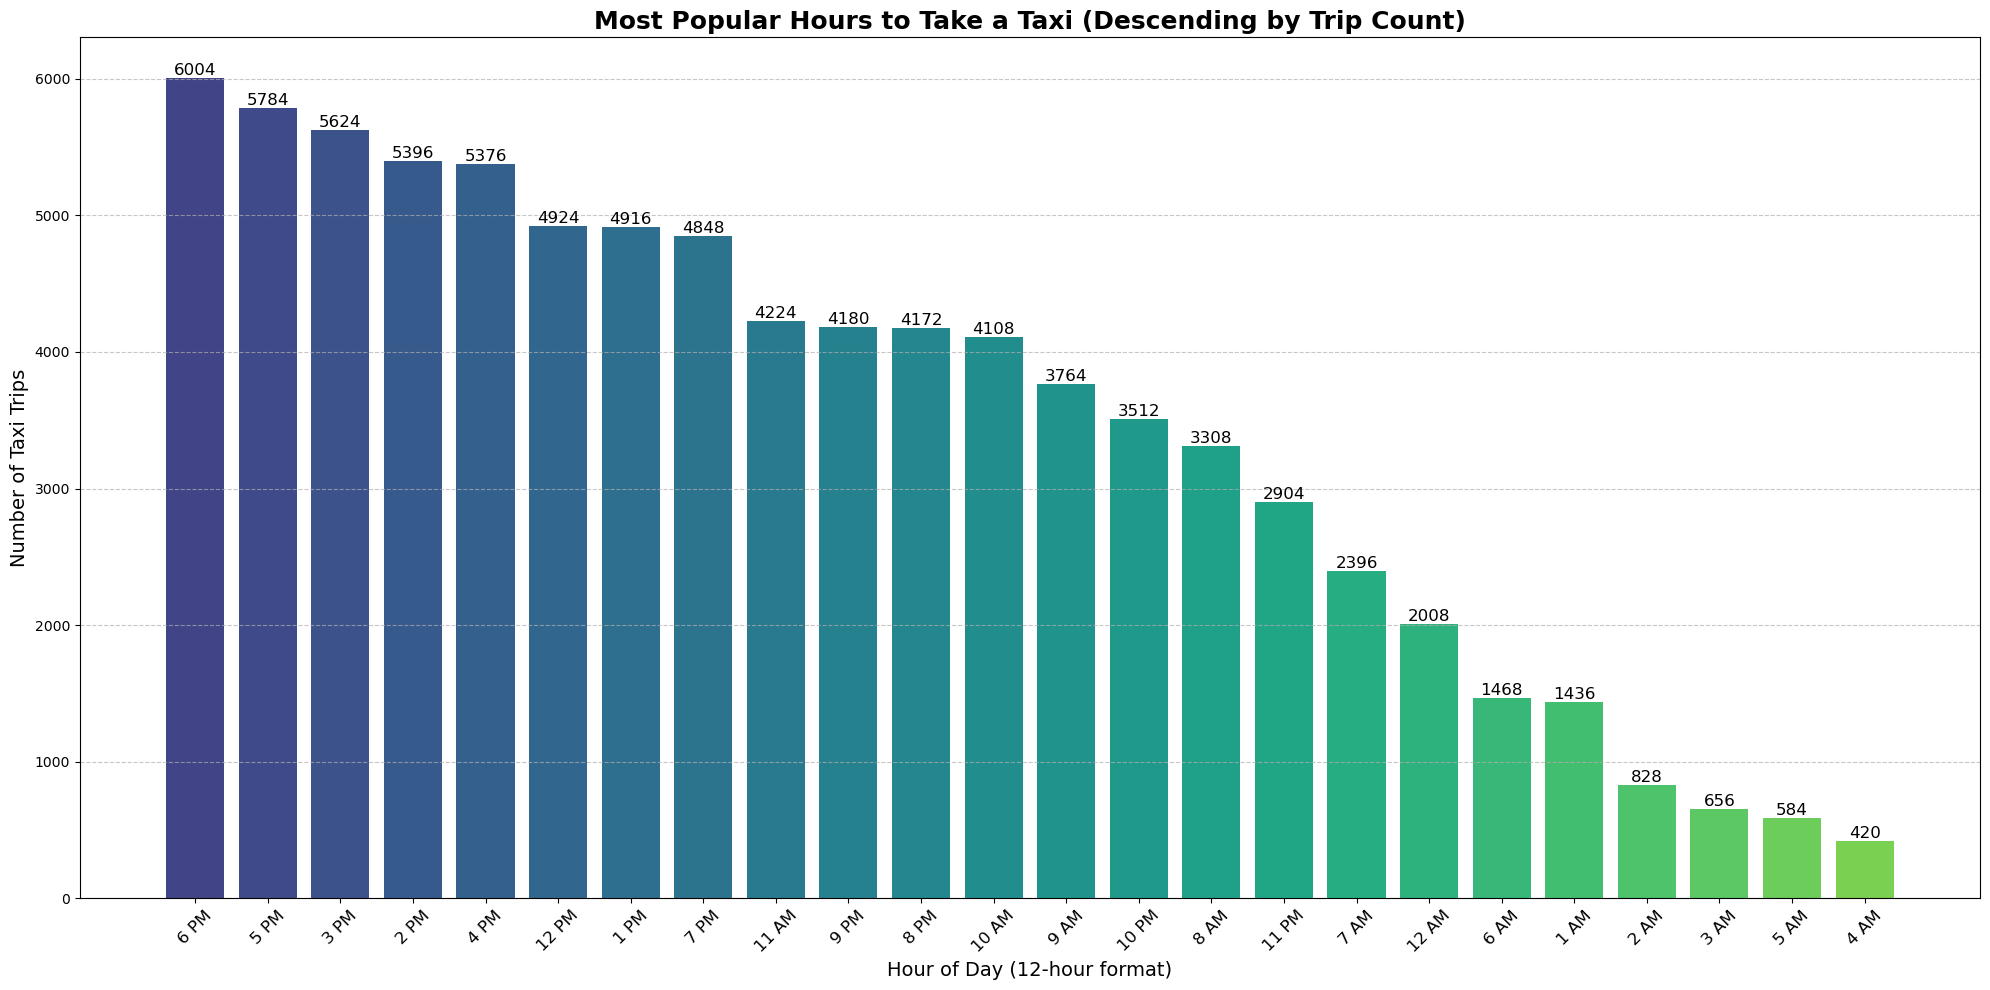

In [499]:
# Step 3: Fetch the data and plot the visualization
data_for_visual_1 = get_data_for_visual_1()
plot_visual_1(data_for_visual_1)

# Animated Visualization 1: What’s the most popular hour to take a taxi?

This animated visualization enhances the static bar chart by dynamically building the bars hour by hour, creating a compelling and engaging way to observe the distribution of taxi trips throughout the day. The goal is to emphasize the progression and magnitude of taxi usage across different hours.

### Description of the Animation
- The animation starts with an empty chart and progressively fills the bars in descending order of popularity.
- Each bar represents an hour of the day and is annotated with the exact trip count once it reaches its final height.
- The animation highlights the most popular hour (**6 PM**) as the tallest bar, ensuring it stands out during the progression.

### Key Insight
- **6 PM remains the peak hour**, consistent with the static visualization.

### Summary
This animation serves as an engaging tool for understanding taxi trip distribution by hour.

### Output Format
The animation is saved as an **MP4**, providing higher quality for presentations.


In [501]:
# Step 1: Define the function to create the animated visualization
def plot_animated_visual_1(dataframe):
    """
    Create an animated bar chart for the most popular hours to take a taxi.

    Args:
        dataframe (pd.DataFrame): DataFrame containing hours and trip counts.
    """
    # Sort data by trip count in descending order (already sorted in the query)
    dataframe = dataframe.sort_values(by="trip_count", ascending=False)
    
    # Create figure and initial bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(
        dataframe["hour"], 
        dataframe["trip_count"], 
        color=plt.cm.viridis(np.linspace(0.2, 0.8, len(dataframe)))
    )
    
    # Set chart titles and labels
    ax.set_title("Animated Bar Chart: Most Popular Hours to Take a Taxi (2020-2024)", fontsize=16, fontweight="bold")
    ax.set_xlabel("Hour of Day (12-hour format)", fontsize=12)
    ax.set_ylabel("Number of Taxi Trips", fontsize=12)
    ax.set_xticks(range(len(dataframe["hour"])))
    ax.set_xticklabels(dataframe["hour"], rotation=45)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Update function for animation
    def update(frame):
        for i, bar in enumerate(bars):
            if i <= frame:
                height = dataframe["trip_count"].iloc[i]
                bar.set_height(height)
                bar.set_color(plt.cm.viridis(frame / len(dataframe)))

                # Clear previous text annotations
                for txt in ax.texts:
                    txt.remove()
                
                # Add text annotation slightly above the bar
                ax.text(
                    bar.get_x() + bar.get_width() / 2, 
                    bar.get_height() + 0.01 * height, 
                    f"{int(height)}", 
                    ha="center", 
                    va="bottom", 
                    fontsize=10, 
                    color="black"
                )
        return bars

    # Create and save animation
    anim = FuncAnimation(fig, update, frames=len(dataframe), interval=200, repeat=False)
    try:
        anim.save("animated_bar_chart.mp4", writer="ffmpeg")
        print("Animation saved as MP4: animated_bar_chart.mp4")
    except Exception as e:
        print("ffmpeg not available. Saving as GIF instead.")
        anim.save("animated_bar_chart.gif", writer="pillow")
        print("Animation saved as GIF: animated_bar_chart.gif")

    # Display the saved animation
    from IPython.display import Video, Image
    try:
        display(Video("animated_bar_chart.mp4"))
    except:
        display(Image("animated_bar_chart.gif"))

In [502]:
# Step 2: Define the function to retrieve data from the database
def get_data_for_animated_visual_1():
    """
    Query the database to retrieve data for the animated bar chart of most popular hours.

    Returns:
        pd.DataFrame: A DataFrame containing hours and corresponding trip counts.
    """
    QUERY_1 = """
    SELECT 
        strftime('%H', pickup_datetime) AS hour,
        COUNT(*) AS trip_count
    FROM 
        taxi_trips
    WHERE 
        DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY 
        hour
    ORDER BY 
        trip_count DESC;
    """
    with engine.connect() as con:
        results = con.execute(db_text(QUERY_1)).fetchall()
    
    # Convert results to a pandas DataFrame
    df = pd.DataFrame(results, columns=["hour", "trip_count"])
    
    # Convert hour to a 12-hour format for readability
    df["hour"] = df["hour"].astype(int).apply(convert_to_12_hour)
    return df

Animation saved as MP4: animated_bar_chart.mp4


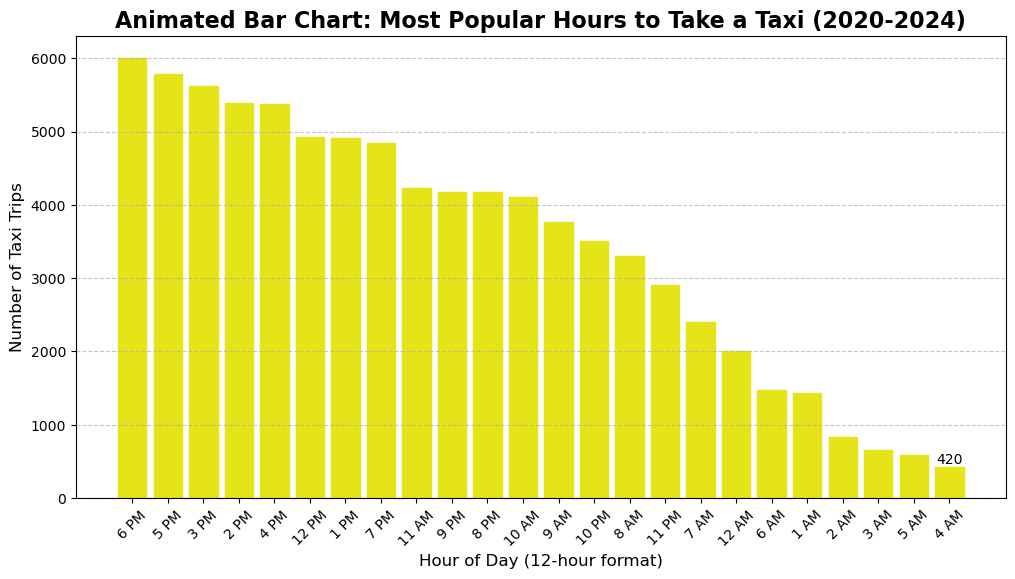

In [503]:
# Step 3: Retrieve data and plot the animated visualization
data_for_animated_visual_1 = get_data_for_animated_visual_1()
plot_animated_visual_1(data_for_animated_visual_1)

# Visualization 2: What’s the most popular month to hire a cab or Uber?

This visualization explores the average distance traveled per month for all rides (both taxi and Uber) from January 2020 to August 2024. The inclusion of 90% confidence intervals provides insights into the variability and reliability of the data for each month.

### Description of the Chart
- **X-axis**: Displays months from January to December in chronological order.
- **Y-axis**: Shows the average distance traveled (in miles) per ride.
- **Bars**: Represent the average distance for each month, with distinct colors to differentiate between months.
- **Error Bars**: Highlight the 90% confidence interval for the average distance, helping to visualize the data's variability.

### Key Insight
- **June** show a higher average distance compared to others (as the tallest bar), possibly indicating specific events or seasonal trends.
- The confidence intervals suggest that the data is relatively consistent, with minor variability in some months.

### Summary
This visualization provides a clear and concise overview of monthly trends in ride distances, revealing both the average distances and the reliability of the data. 

### Output Format
A static bar chart with error bars, emphasizing both the averages and variability.


In [509]:
# Step 1: Define the visualization function
def plot_visual_2(dataframe):
    """
    Create a bar chart to visualize the average distance traveled per month
    with a 90% confidence interval.

    Args:
        dataframe (pd.DataFrame): DataFrame containing month, average distance,
                                  sample size, and confidence intervals.
    """
    # Convert month to integers for plotting
    dataframe['month'] = dataframe['month'].astype(int)
    
    # Define colors for the bars
    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, len(dataframe['month'])))
    
    # Plot the bar chart with confidence intervals
    plt.figure(figsize=(16, 10))
    bars = plt.bar(
        dataframe['month'], 
        dataframe['avg_distance'], 
        yerr=[dataframe['avg_distance'] - dataframe['ci_lower'], dataframe['ci_upper'] - dataframe['avg_distance']],
        capsize=5, 
        color=colors, 
        alpha=0.8, 
        width=0.6, 
        label="Average Distance"
    )
    
    # Annotate the bars
    for bar, avg in zip(bars, dataframe['avg_distance']):
        plt.text(bar.get_x() + bar.get_width() / 2, 
                 bar.get_height() + 0.2, 
                 f"{avg:.2f}", 
                 ha='center', 
                 va='bottom', 
                 fontsize=10)
    
    # Add labels, title, and styling
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Month", fontsize=14, labelpad=10)
    plt.ylabel("Average Distance (miles)", fontsize=14, labelpad=10)
    plt.title("Average Distance Traveled Per Month (2020-2024)\nwith 90% Confidence Interval", fontsize=16, pad=20, weight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [511]:
# Step 2: Define the function to retrieve and process data
def get_data_for_visual_2():
    """
    Query the database to retrieve data for visualizing the average distance
    traveled per month with confidence intervals.

    Returns:
        pd.DataFrame: A DataFrame containing month, average distance, 
                      standard deviation, sample size, and confidence intervals.
    """
    query = """
    WITH combined_data AS (
        SELECT 
            strftime('%m', pickup_datetime) AS month,
            trip_miles AS distance
        FROM taxi_trips
        WHERE DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
        UNION ALL
        SELECT 
            strftime('%m', pickup_datetime) AS month,
            trip_miles AS distance
        FROM uber_trips
        WHERE DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
    )
    SELECT
        month,
        AVG(distance) AS avg_distance,
        COUNT(distance) AS sample_size
    FROM
        combined_data
    GROUP BY
        month
    ORDER BY
        CAST(month AS INTEGER);
    """
    with engine.connect() as con:
        results = con.execute(db.text(query)).fetchall()
        columns = ["month", "avg_distance", "sample_size"]
        dataframe = pd.DataFrame(results, columns=columns)

    # Calculate standard deviation and confidence intervals
    stddevs = []
    for month in dataframe['month']:
        query_stddev = f"""
        WITH combined_data AS (
            SELECT 
                trip_miles AS distance
            FROM taxi_trips
            WHERE strftime('%m', pickup_datetime) = '{int(month):02d}' 
              AND DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
            UNION ALL
            SELECT 
                trip_miles AS distance
            FROM uber_trips
            WHERE strftime('%m', pickup_datetime) = '{int(month):02d}' 
              AND DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
        )
        SELECT
            distance
        FROM
            combined_data;
        """
        with engine.connect() as con:
            distances = pd.read_sql(query_stddev, con)['distance']
            stddevs.append(distances.std())
    
    dataframe['stddev_distance'] = stddevs
    dataframe['ci_upper'] = dataframe['avg_distance'] + 1.645 * (dataframe['stddev_distance'] / np.sqrt(dataframe['sample_size']))
    dataframe['ci_lower'] = dataframe['avg_distance'] - 1.645 * (dataframe['stddev_distance'] / np.sqrt(dataframe['sample_size']))
    
    return dataframe

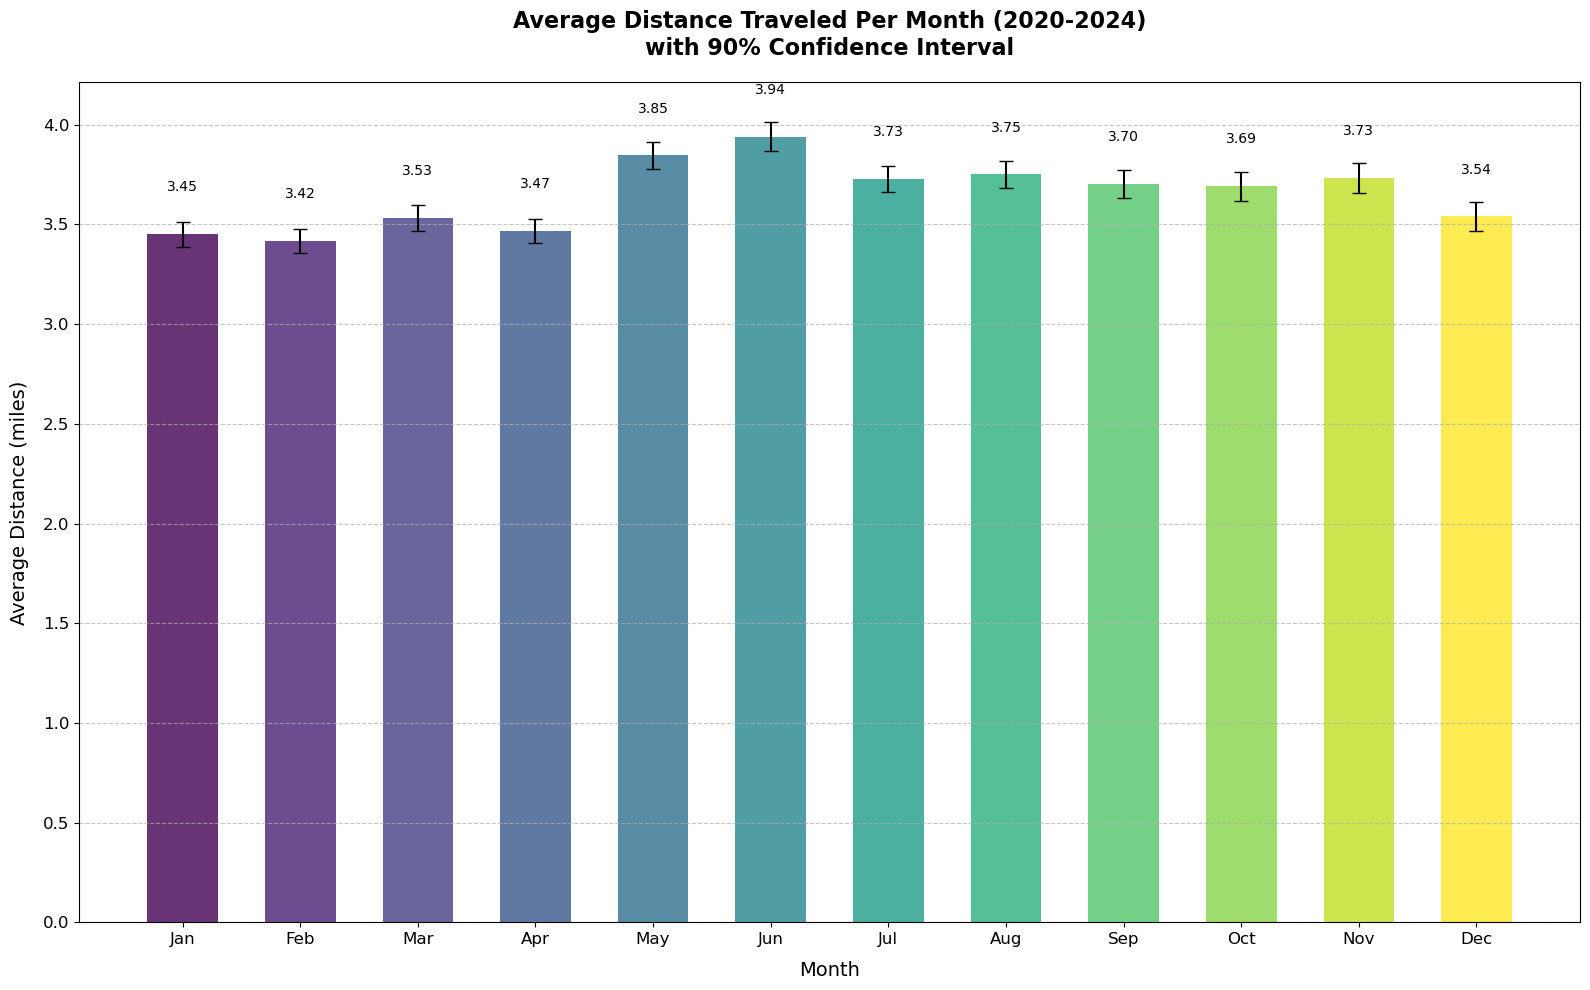

In [513]:
# Step 3: Fetch the data and plot the visualization
visual_2_data = get_data_for_visual_2()
plot_visual_2(visual_2_data)

# Visualization 3: Which Day of the Week is Most Popular for Taking a Ride to an NYC-Based Airport?

This visualization identifies the most popular days of the week for ride drop-offs at the three major NYC airports: JFK, LaGuardia (LGA), and Newark (EWR), during the period from 2020 to 2024. The aim is to highlight airport traffic patterns based on day-of-week preferences.

### Description of the Chart
- **X-axis**: Represents the days of the week, ranging from Monday to Sunday.
- **Y-axis**: Indicates the number of trips (trip counts) for each airport.
- **Bars**: Grouped by airport (JFK, LGA, and EWR) with distinct colors for each airport.
- **Annotations**: Each bar is annotated with its corresponding trip count to enhance clarity and precision.

### Key Insight
- **Friday** tend to be the most popular days for airport drop-offs, possibly due to business travel and weekend trips.
- EWR shows relatively lower traffic compared to the other two airports.

### Summary
This grouped bar chart effectively illustrates the weekly trends in airport drop-offs, revealing patterns in airport usage based on travel behavior. 

### Output Format
A grouped bar chart with annotated values for trip counts, visually distinguishing traffic patterns across days and airports.


In [516]:
# Step 1: Define the visualization function
def plot_visual_3(dataframe):
    """
    Create a grouped bar chart to visualize the most popular days
    for airport drop-offs at JFK, LGA, and EWR.

    Args:
        dataframe (pd.DataFrame): DataFrame containing columns "day_of_week",
                                  "airport", and "trip_count".
    """
    # Pivot the dataframe for grouped bar plot
    pivot_df = dataframe.pivot(index="day_of_week", columns="airport", values="trip_count").fillna(0)
    pivot_df = pivot_df.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
    
    # Set pastel color palette
    pastel_colors = sns.color_palette("pastel", len(pivot_df.columns))
    
    # Create the grouped bar chart
    ax = pivot_df.plot(
        kind="bar", 
        figsize=(14, 8), 
        color=pastel_colors, 
        alpha=0.85, 
        width=0.85  # Adjust bar width
    )
    
    # Customization
    ax.set_title("Most Popular Days for Airport Drop-Offs (2020-2024)", fontsize=16, weight="bold")
    ax.set_ylabel("Number of Trips", fontsize=14)
    ax.set_xlabel("Day of Week", fontsize=14)
    ax.legend(title="Airport", fontsize=12)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Annotate bar values
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(
                f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', 
                va='bottom', 
                fontsize=10
            )
    
    plt.tight_layout()
    plt.show()

In [518]:
# Step 2: Define the function to fetch and process data
def get_data_for_visual_3():
    """
    Query the database to fetch data on airport drop-offs by day of the week.

    Returns:
        pd.DataFrame: A DataFrame containing "airport", "day_of_week", and "trip_count".
    """
    AIRPORT_BOUNDS = {
        "LGA": {"lat_min": 40.763589, "lat_max": 40.778865, "lon_min": -73.891745, "lon_max": -73.854838},
        "JFK": {"lat_min": 40.639263, "lat_max": 40.651376, "lon_min": -73.795642, "lon_max": -73.766264},
        "EWR": {"lat_min": 40.686794, "lat_max": 40.699680, "lon_min": -74.194028, "lon_max": -74.165205},
    }
    
    query = f"""
    WITH dropoffs_to_airports AS (
        SELECT
            CASE
                WHEN do_lat BETWEEN {AIRPORT_BOUNDS["LGA"]["lat_min"]} AND {AIRPORT_BOUNDS["LGA"]["lat_max"]}
                     AND do_lon BETWEEN {AIRPORT_BOUNDS["LGA"]["lon_min"]} AND {AIRPORT_BOUNDS["LGA"]["lon_max"]} THEN 'LGA'
                WHEN do_lat BETWEEN {AIRPORT_BOUNDS["JFK"]["lat_min"]} AND {AIRPORT_BOUNDS["JFK"]["lat_max"]}
                     AND do_lon BETWEEN {AIRPORT_BOUNDS["JFK"]["lon_min"]} AND {AIRPORT_BOUNDS["JFK"]["lon_max"]} THEN 'JFK'
                WHEN do_lat BETWEEN {AIRPORT_BOUNDS["EWR"]["lat_min"]} AND {AIRPORT_BOUNDS["EWR"]["lat_max"]}
                     AND do_lon BETWEEN {AIRPORT_BOUNDS["EWR"]["lon_min"]} AND {AIRPORT_BOUNDS["EWR"]["lon_max"]} THEN 'EWR'
                ELSE NULL
            END AS airport,
            strftime('%w', dropoff_datetime) AS day_of_week
        FROM
            taxi_trips
        WHERE
            DATE(dropoff_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
        UNION ALL
        SELECT
            CASE
                WHEN do_lat BETWEEN {AIRPORT_BOUNDS["LGA"]["lat_min"]} AND {AIRPORT_BOUNDS["LGA"]["lat_max"]}
                     AND do_lon BETWEEN {AIRPORT_BOUNDS["LGA"]["lon_min"]} AND {AIRPORT_BOUNDS["LGA"]["lon_max"]} THEN 'LGA'
                WHEN do_lat BETWEEN {AIRPORT_BOUNDS["JFK"]["lat_min"]} AND {AIRPORT_BOUNDS["JFK"]["lat_max"]}
                     AND do_lon BETWEEN {AIRPORT_BOUNDS["JFK"]["lon_min"]} AND {AIRPORT_BOUNDS["JFK"]["lon_max"]} THEN 'JFK'
                WHEN do_lat BETWEEN {AIRPORT_BOUNDS["EWR"]["lat_min"]} AND {AIRPORT_BOUNDS["EWR"]["lat_max"]}
                     AND do_lon BETWEEN {AIRPORT_BOUNDS["EWR"]["lon_min"]} AND {AIRPORT_BOUNDS["EWR"]["lon_max"]} THEN 'EWR'
                ELSE NULL
            END AS airport,
            strftime('%w', dropoff_datetime) AS day_of_week
        FROM
            uber_trips
        WHERE
            DATE(dropoff_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
    ),
    grouped_data AS (
        SELECT
            airport,
            CASE day_of_week
                WHEN '0' THEN 'Sunday'
                WHEN '1' THEN 'Monday'
                WHEN '2' THEN 'Tuesday'
                WHEN '3' THEN 'Wednesday'
                WHEN '4' THEN 'Thursday'
                WHEN '5' THEN 'Friday'
                WHEN '6' THEN 'Saturday'
            END AS day_of_week,
            COUNT(*) AS trip_count
        FROM
            dropoffs_to_airports
        WHERE
            airport IS NOT NULL
        GROUP BY
            airport, day_of_week
    )
    SELECT
        airport,
        day_of_week,
        trip_count
    FROM
        grouped_data
    ORDER BY
        airport, trip_count DESC;
    """
    with engine.connect() as con:
        results = con.execute(db.text(query)).fetchall()
        columns = ["airport", "day_of_week", "trip_count"]
        return pd.DataFrame(results, columns=columns)

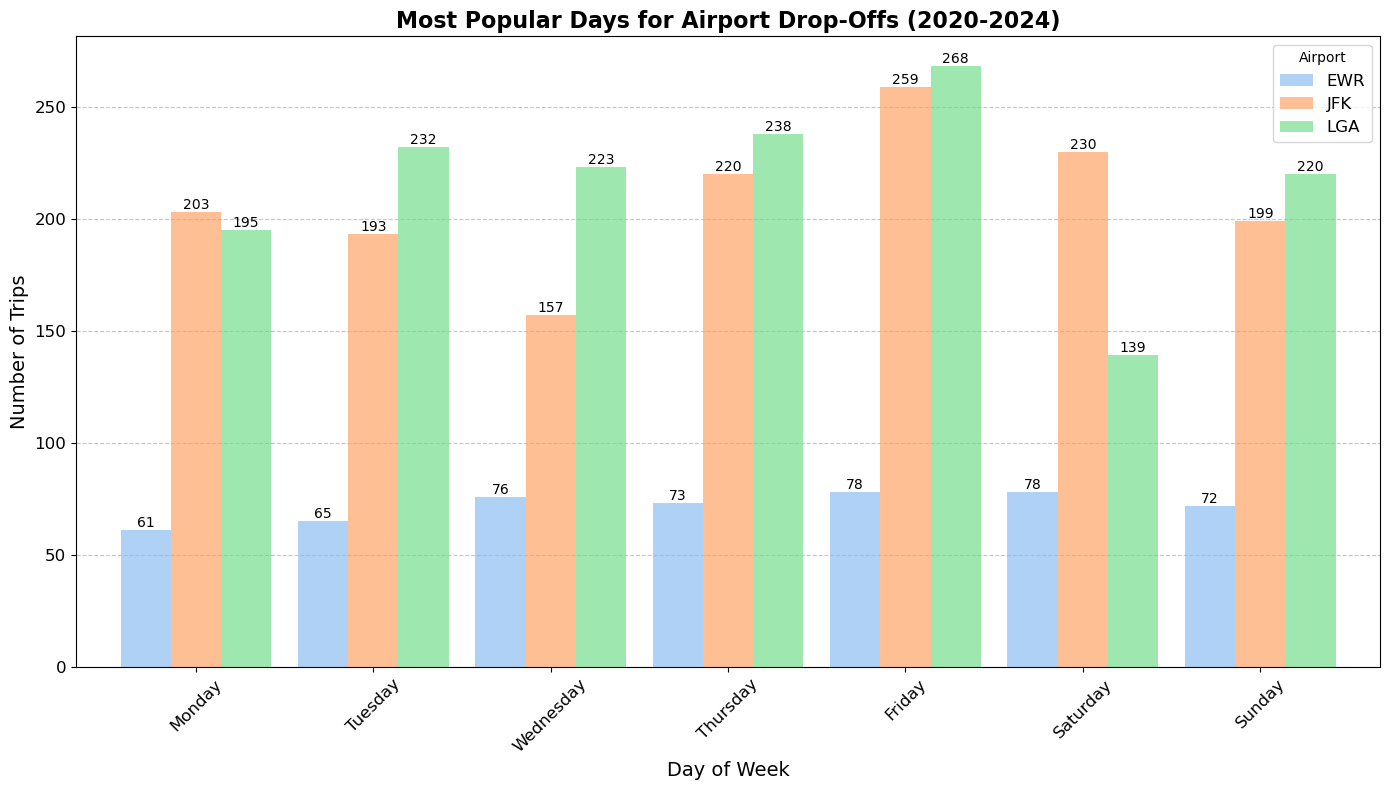

In [520]:
# Step 3: Fetch the data and plot the visualization
visual_3_data = get_data_for_visual_3()
plot_visual_3(visual_3_data)

# Visualization 4: How much do hired rides earn in total fares monthly?

### Objective
This visualization compares the total monthly earnings of taxi and Uber services over time, from January 2020 to August 2024.

### Output
A dual-bar chart where each month displays the earnings for both taxis and Ubers side by side.

In [543]:
def get_data_for_visual_4():
    """
    Fetch data for visualization 4: Total monthly earnings for taxis and Ubers.
    Returns a pandas DataFrame.
    """
    QUERY_4 = """
    WITH taxi_monthly_earnings AS (
        SELECT
            strftime('%Y-%m', pickup_datetime) AS taxi_month,
            SUM(fare_amount) AS taxi_fares,
            SUM(mta_tax + improvement_surcharge + congestion_surcharge + airport_fee) AS taxi_taxes,
            SUM(tolls_amount) AS taxi_tolls,
            SUM(total_amount) AS taxi_total_fares
        FROM taxi_trips
        WHERE DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
        GROUP BY taxi_month
    ),
    uber_monthly_earnings AS (
        SELECT
            strftime('%Y-%m', pickup_datetime) AS uber_month,
            SUM(fare_amount) AS uber_fares,
            SUM(sales_tax + bcf + congestion_surcharge + airport_fee) AS uber_taxes,
            SUM(tolls_amount) AS uber_tolls,
            SUM(fare_amount + sales_tax + bcf + congestion_surcharge + airport_fee + tolls_amount) AS uber_total_fares
        FROM uber_trips
        WHERE DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
        GROUP BY uber_month
    )
    SELECT
        months.month AS month,
        COALESCE(tme.taxi_fares, 0) AS taxi_fares,
        COALESCE(tme.taxi_taxes, 0) AS taxi_taxes,
        COALESCE(tme.taxi_tolls, 0) AS taxi_tolls,
        COALESCE(tme.taxi_total_fares, 0) AS taxi_total_fares,
        COALESCE(ume.uber_fares, 0) AS uber_fares,
        COALESCE(ume.uber_taxes, 0) AS uber_taxes,
        COALESCE(ume.uber_tolls, 0) AS uber_tolls,
        COALESCE(ume.uber_total_fares, 0) AS uber_total_fares
    FROM
        (SELECT DISTINCT strftime('%Y-%m', pickup_datetime) AS month FROM taxi_trips
         UNION
         SELECT DISTINCT strftime('%Y-%m', pickup_datetime) AS month FROM uber_trips) months
    LEFT JOIN taxi_monthly_earnings tme ON months.month = tme.taxi_month
    LEFT JOIN uber_monthly_earnings ume ON months.month = ume.uber_month
    ORDER BY month;
    """
    
    # Connect to the database and execute the query
    engine = db.create_engine(DATABASE_URL)
    with engine.connect() as con:
        results = con.execute(db.text(QUERY_4)).fetchall()

    # Convert results to a pandas DataFrame
    columns = [
        "month", 
        "taxi_fares", "taxi_taxes", "taxi_tolls", "taxi_total_fares", 
        "uber_fares", "uber_taxes", "uber_tolls", "uber_total_fares"
    ]
    return pd.DataFrame(results, columns=columns)

In [545]:
def plot_visual_4(dataframe):
    """
    Create a visualization for total monthly earnings (taxi vs Uber).
    This includes a breakdown of fares, surcharges, taxes, and tolls.
    """
    # Convert 'month' to datetime for proper plotting
    dataframe["month"] = pd.to_datetime(dataframe["month"], format='%Y-%m')

    # Set figure size
    plt.figure(figsize=(14, 8))

    # Define macaron-style colors
    taxi_fare_color = "#A8D5BA"  # Pastel green
    taxi_tax_color = "#FFD3B5"  # Pastel peach
    taxi_toll_color = "#F9AFAF"  # Pastel red
    uber_fare_color = "#B5D8F9"  # Pastel blue
    uber_tax_color = "#C6A8D5"  # Pastel purple
    uber_toll_color = "#F9F5AF"  # Pastel yellow

    # Plot Taxi Earnings
    plt.bar(dataframe["month"] - pd.Timedelta(days=10), dataframe["taxi_total_fares"], 
            width=20, label="Taxi Total Fares", color=taxi_fare_color, align="center")
    plt.bar(dataframe["month"] - pd.Timedelta(days=10), dataframe["taxi_taxes"], 
            width=20, label="Taxi Taxes", color=taxi_tax_color, align="center")
    plt.bar(dataframe["month"] - pd.Timedelta(days=10), dataframe["taxi_tolls"], 
            width=20, label="Taxi Tolls", color=taxi_toll_color, align="center")

    # Plot Uber Earnings
    plt.bar(dataframe["month"] + pd.Timedelta(days=10), dataframe["uber_total_fares"], 
            width=20, label="Uber Total Fares", color=uber_fare_color, align="center")
    plt.bar(dataframe["month"] + pd.Timedelta(days=10), dataframe["uber_taxes"], 
            width=20, label="Uber Taxes", color=uber_tax_color, align="center")
    plt.bar(dataframe["month"] + pd.Timedelta(days=10), dataframe["uber_tolls"], 
            width=20, label="Uber Tolls", color=uber_toll_color, align="center")

    # Add labels and title
    plt.xlabel("Month", fontsize=14)
    plt.ylabel("Total Earnings ($)", fontsize=14)
    plt.title("Monthly Total Earnings (2020-2024): Taxi vs Uber", fontsize=16)
    plt.legend(fontsize=12, loc="upper left")

    # Rotate x-axis labels
    plt.xticks(dataframe["month"], 
               dataframe["month"].dt.strftime('%Y-%m'), 
               rotation=45, ha='right', fontsize=10)

    # Show grid lines
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

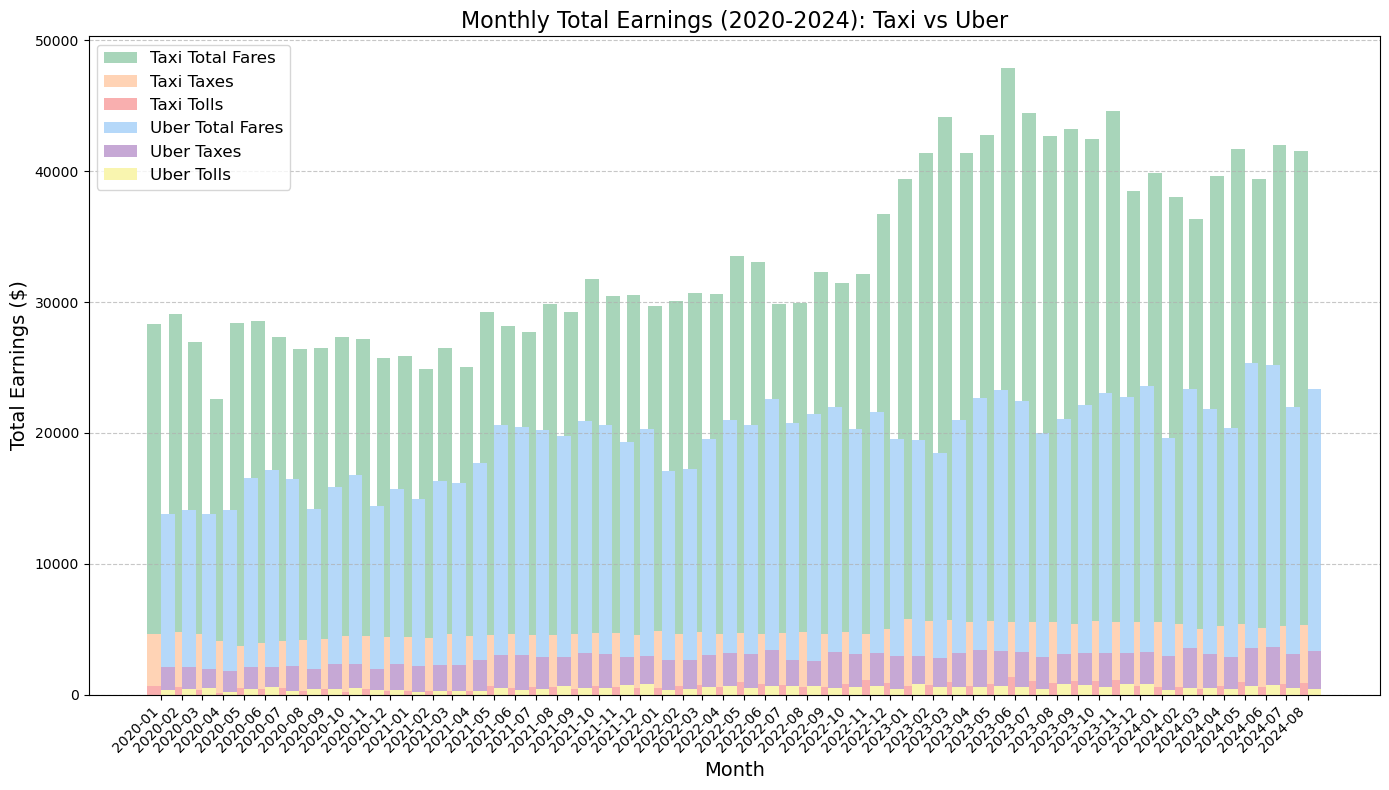

In [547]:
# Fetch the data
visual_4_data = get_data_for_visual_4()

# Plot the visualization
plot_visual_4(visual_4_data)

# Visualization 5: Does precipitation or distance traveled affect the amount of tip?

This visualization examines the impact of two key factors on the tip amounts:
1. **Distance traveled**: For both taxis and Ubers, we investigate how the length of a trip correlates with the tip amount given by passengers.
2. **Precipitation levels**: We explore whether rainfall influences tip behavior for both taxis and Ubers.

By splitting the analysis into these two variables, we aim to identify trends or relationships that might provide insights into passenger tipping behavior under varying conditions.

### Visualization Explanation
The output consists of **four scatter plots** arranged in a 2x2 grid:
1. **Taxi: Distance vs. Tip**  
   The first plot displays how taxi trip distances correspond to the tip amounts. It helps identify whether longer distances encourage larger tips.
   
2. **Uber: Distance vs. Tip**  
   The second plot highlights the same relationship as above but for Uber trips. Comparing this to the taxi chart can reveal potential differences in tipping trends between the two ride types.
   
3. **Taxi: Precipitation vs. Tip**  
   The third plot shows whether rainy conditions affect taxi tips. It highlights how precipitation (measured in inches) correlates with the tip amounts.
   
4. **Uber: Precipitation vs. Tip**  
   The fourth plot examines the same precipitation-tip relationship for Uber rides, enabling a comparison to taxis under similar weather conditions.

Each scatter plot includes:
- **X-axis**: Distance (in miles) or precipitation (in inches), depending on the variable being analyzed.
- **Y-axis**: Tip amounts (in USD).
- **Gridlines**: To improve readability of data points.
- **Title**: Clearly labeling each plot for easy interpretation.

### Conclusion
- **Distance vs. Tip**: The plots indicate a positive correlation for both taxis and Ubers, with longer distances generally leading to higher tips. However, the increase may plateau after a certain point, reflecting tipping norms or passenger budgets.
- **Precipitation vs. Tip**: There appears to be little or no clear relationship between precipitation levels and tip amounts. This could suggest that weather conditions may not significantly influence tipping behavior, or that the sample size during extreme weather is limited.

Overall, the visualizations provide a nuanced view of tipping patterns, with distance playing a more pronounced role compared to precipitation.

In [ ]:
def get_data_for_visual_5():
    """
    Fetches data for scatter plots showing the relationship between distance, precipitation, and tip amount.
    Returns a dictionary of dataframes for Taxi and Uber (distance and precipitation data).
    """
    queries = {
        "taxi_distance": """
            SELECT 
                trip_miles AS x, 
                (total_amount - (total_amount * 0.1)) AS y 
            FROM 
                taxi_trips
            WHERE 
                DATE(pickup_datetime) BETWEEN '2022-01-01' AND '2023-12-31'
                AND trip_miles > 0
                AND (total_amount - (total_amount * 0.1)) BETWEEN 0 AND 50;
        """,
        "uber_distance": """
            SELECT 
                trip_miles AS x, 
                (total_amount - (total_amount * 0.1)) AS y 
            FROM 
                uber_trips
            WHERE 
                DATE(pickup_datetime) BETWEEN '2022-01-01' AND '2023-12-31'
                AND trip_miles > 0
                AND (total_amount - (total_amount * 0.1)) BETWEEN 0 AND 50;
        """,
        "taxi_precipitation": """
            SELECT 
                hw.precipitation AS x, 
                (tt.total_amount - (tt.total_amount * 0.1)) AS y 
            FROM 
                taxi_trips tt
            LEFT JOIN 
                hourly_weather hw 
            ON 
                DATE(tt.pickup_datetime) = DATE(hw.date)
            WHERE 
                DATE(tt.pickup_datetime) BETWEEN '2022-01-01' AND '2023-12-31'
                AND hw.precipitation IS NOT NULL
                AND (tt.total_amount - (tt.total_amount * 0.1)) BETWEEN 0 AND 50;
        """,
        "uber_precipitation": """
            SELECT 
                hw.precipitation AS x, 
                (ut.total_amount - (ut.total_amount * 0.1)) AS y 
            FROM 
                uber_trips ut
            LEFT JOIN 
                hourly_weather hw 
            ON 
                DATE(ut.pickup_datetime) = DATE(hw.date)
            WHERE 
                DATE(ut.pickup_datetime) BETWEEN '2022-01-01' AND '2023-12-31'
                AND hw.precipitation IS NOT NULL
                AND (ut.total_amount - (ut.total_amount * 0.1)) BETWEEN 0 AND 50;
        """
    }

    dataframes = {}
    with engine.connect() as con:
        for key, query in queries.items():
            result = con.execute(db_text(query)).fetchall()
            dataframes[key] = pd.DataFrame(result, columns=["x", "y"])

    return dataframes

def plot_visual_5(dataframes):
    """
    Plots scatter plots showing the effect of distance and precipitation on tip amounts.
    Creates a 2x2 grid of subplots.
    """
    # Extract data from the dictionary
    taxi_distance = dataframes["taxi_distance"]
    uber_distance = dataframes["uber_distance"]
    taxi_precipitation = dataframes["taxi_precipitation"]
    uber_precipitation = dataframes["uber_precipitation"]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Effect of Distance and Precipitation on Tip Amounts (2022-2023)", fontsize=16, weight='bold')

    # Taxi Distance vs Tip
    axes[0, 0].scatter(taxi_distance['x'], taxi_distance['y'], alpha=0.6, color='blue', label='Taxi')
    axes[0, 0].set_title("Taxi Distance vs Tip")
    axes[0, 0].set_xlabel("Distance (miles)")
    axes[0, 0].set_ylabel("Tip Amount (USD)")
    axes[0, 0].grid(True)
    
    # Uber Distance vs Tip
    axes[0, 1].scatter(uber_distance['x'], uber_distance['y'], alpha=0.6, color='green', label='Uber')
    axes[0, 1].set_title("Uber Distance vs Tip")
    axes[0, 1].set_xlabel("Distance (miles)")
    axes[0, 1].set_ylabel("Tip Amount (USD)")
    axes[0, 1].grid(True)

    # Taxi Precipitation vs Tip
    axes[1, 0].scatter(taxi_precipitation['x'], taxi_precipitation['y'], alpha=0.6, color='orange', label='Taxi')
    axes[1, 0].set_title("Taxi Precipitation vs Tip")
    axes[1, 0].set_xlabel("Precipitation (inches)")
    axes[1, 0].set_ylabel("Tip Amount (USD)")
    axes[1, 0].grid(True)

    # Uber Precipitation vs Tip
    axes[1, 1].scatter(uber_precipitation['x'], uber_precipitation['y'], alpha=0.6, color='purple', label='Uber')
    axes[1, 1].set_title("Uber Precipitation vs Tip")
    axes[1, 1].set_xlabel("Precipitation (inches)")
    axes[1, 1].set_ylabel("Tip Amount (USD)")
    axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Fetch the data
visual_5_data = get_data_for_visual_5()

# Plot the visualization
plot_visual_5(visual_5_data)


# Visualization 6: Heatmap of All Hired Trips in 2020

This visualization illustrates the geographic density of hired trips (both taxi and Uber) across New York City in the year 2020. By including both pickup and dropoff locations, the heatmap provides a comprehensive view of where rides are initiated and concluded.

### Visualization Explanation
The output is an **interactive heatmap** displayed on a map of NYC:
- **Heatmap Intensity**: The brighter and denser the color, the higher the concentration of pickups and dropoffs in that area. This visualizes the busiest areas for rides.
- **Coverage**: The map spans all five boroughs of NYC, ensuring complete coverage and showcasing demand across the city.
- **Interactivity**: Users can zoom in/out and pan around the map to explore specific neighborhoods or regions in greater detail, providing an intuitive way to investigate ride patterns.

### Key Features
1. **Comprehensive Data**: 
   - Includes both pickup and dropoff locations for all rides (taxi and Uber).
   - Ensures that the heatmap represents not only where trips begin but also where they end, capturing a full picture of ride demand.
2. **Timeframe**: 
   - Data includes all trips during 2020, offering insights into ride patterns throughout the year.
3. **Saved Output**: 
   - The heatmap is saved as an HTML file, making it shareable and viewable in any web browser, even without specialized visualization software.

### Conclusion
- **Manhattan Dominates**: As expected, Manhattan shows the highest density of trips, particularly in areas like Midtown, the Financial District, and around major transit hubs such as Penn Station and Grand Central Terminal.
- **Outer Borough Activity**: While Manhattan leads in demand, significant hotspots are visible in the outer boroughs:
  - **Brooklyn**: Downtown Brooklyn and Williamsburg show strong activity.
  - **Queens**: Areas near JFK and LaGuardia airports, as well as Flushing, emerge as key transit points.
  - **Bronx and Staten Island**: While less dense, some hotspots are noticeable near major highways and commercial centers.
  
### Note
The heatmap includes both pickup and dropoff points, which may lead to overlapping data in high-density areas like Manhattan. Adjusting the radius and blur settings helps balance clarity and detail in the visualization.

In [ ]:
# Using the pre-defined database URL
engine = create_engine(DATABASE_URL)

# SQL Query to fetch trip data for 2020 (both pickup and dropoff)
QUERY_TRIP_COORDINATES = """
SELECT 
    pu_lat AS latitude, 
    pu_lon AS longitude
FROM 
    taxi_trips
WHERE 
    DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2020-12-31'
    AND pu_lat IS NOT NULL
    AND pu_lon IS NOT NULL
UNION ALL
SELECT 
    do_lat AS latitude, 
    do_lon AS longitude
FROM 
    taxi_trips
WHERE 
    DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2020-12-31'
    AND do_lat IS NOT NULL
    AND do_lon IS NOT NULL
UNION ALL
SELECT 
    pu_lat AS latitude, 
    pu_lon AS longitude
FROM 
    uber_trips
WHERE 
    DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2020-12-31'
    AND pu_lat IS NOT NULL
    AND pu_lon IS NOT NULL
UNION ALL
SELECT 
    do_lat AS latitude, 
    do_lon AS longitude
FROM 
    uber_trips
WHERE 
    DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2020-12-31'
    AND do_lat IS NOT NULL
    AND do_lon IS NOT NULL;
"""

# Fetch trip data for 2020
def fetch_trip_coordinates(query):
    """
    Fetch trip coordinates (both pickup and dropoff) for the year 2020.

    Args:
        query (str): SQL query to fetch latitude and longitude data.

    Returns:
        pd.DataFrame: DataFrame with latitude and longitude columns.
    """
    with engine.connect() as con:
        result = con.execute(db_text(query)).fetchall()
        return pd.DataFrame(result, columns=["latitude", "longitude"])

trip_data = fetch_trip_coordinates(QUERY_TRIP_COORDINATES)

# Create a HeatMap
def create_heatmap(trip_data, location, zoom_start=12, map_file="heatmap_2020.html"):
    """
    Creates a heatmap of trip data and saves it as an HTML file.
    
    Args:
        trip_data (pd.DataFrame): DataFrame with latitude and longitude columns.
        location (tuple): The central location for the heatmap (latitude, longitude).
        zoom_start (int): Initial zoom level for the map.
        map_file (str): Path to save the heatmap as an HTML file.
    """
    # Initialize map
    nyc_map = folium.Map(location=location, zoom_start=zoom_start)

    # Prepare data for HeatMap
    heat_data = trip_data[['latitude', 'longitude']].dropna().values.tolist()

    # Add HeatMap layer
    HeatMap(heat_data, radius=8, blur=10, max_zoom=15).add_to(nyc_map)

    # Save map to an HTML file
    nyc_map.save(map_file)
    print(f"Heatmap saved as {map_file}")

# Define the central location for NYC
NYC_LOCATION = (40.7128, -74.0060)  # Latitude and Longitude of NYC

# Create and save the heatmap
create_heatmap(trip_data, location=NYC_LOCATION, map_file="heatmap_2020.html")

In [ ]:
# Display the heatmap inline
IFrame("heatmap_2020.html", width=700, height=500)

## Extra Visulization: How does the number of taxi trips per day vary between daylight and nighttime hours?

This visualization examines how taxi trips vary between daylight and nighttime hours on a daily basis. By integrating data from the `sun` table (sunrise and sunset times) with `taxi_trips`, the analysis highlights patterns in ride demand across different times of the day.

## Visualization Explanation

The output is a **time-series plot**:
- **Two Trend Lines**:
  - One line represents the total number of trips during daylight hours (between sunrise and sunset).
  - The other line shows the total number of trips during nighttime hours (outside sunrise and sunset).
- **Timeframe**: The data spans all available dates, allowing for long-term trends and patterns to be observed.

### Key Features
1. **Daily Analysis**:
   - Visualizes the daily variation in taxi trips between daylight and nighttime.
2. **Integration of Sunrise and Sunset Data**:
   - The division of trips into daytime and nighttime is accurately based on NYC-specific sunrise and sunset times.
3. **Seasonal Trends**:
   - The visualization can reveal seasonal variations, such as higher daytime trips during longer summer days or a spike in nighttime trips during winter holidays.

## Data Preparation

The data is prepared as follows:
1. The `sun` table is joined with the `taxi_trips` table on the `date` column.
2. Trips are categorized as:
   - **Daytime Trips**: Trips where the pickup time falls between sunrise and sunset.
   - **Nighttime Trips**: Trips where the pickup time falls outside this range.

In [ ]:
# Corrected SQL Query to calculate daytime and nighttime trips
query = """
SELECT 
    DATE(t.pickup_datetime) AS date,
    SUM(CASE WHEN TIME(t.pickup_datetime) BETWEEN TIME(s.sunrise) AND TIME(s.sunset) THEN 1 ELSE 0 END) AS daytime_trips,
    SUM(CASE WHEN TIME(t.pickup_datetime) NOT BETWEEN TIME(s.sunrise) AND TIME(s.sunset) THEN 1 ELSE 0 END) AS nighttime_trips
FROM 
    taxi_trips t
JOIN 
    sun s
ON 
    DATE(t.pickup_datetime) = DATE(s.date)
GROUP BY 
    DATE(t.pickup_datetime)
ORDER BY 
    DATE(t.pickup_datetime);
"""

# Execute the query and load results into a DataFrame
try:
    with engine.connect() as connection:
        trip_data = pd.read_sql(query, connection)
except Exception as e:
    print(f"Error executing query: {e}")

# Ensure 'date' is in datetime format for plotting
trip_data['date'] = pd.to_datetime(trip_data['date'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(trip_data['date'], trip_data['daytime_trips'], label='Daytime Trips', linewidth=2)
plt.plot(trip_data['date'], trip_data['nighttime_trips'], label='Nighttime Trips', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.title('Daily Taxi Trips: Daytime vs Nighttime')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()